In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else 'cpu'


%load_ext autoreload
%autoreload 2

/home/clement/anaconda3/envs/rhmc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tvae.data.mnist import Preprocessor
from tvae.utils.logging import configure_logging, get_dirs
from torchvision import datasets
from functools import partial
from torch.utils.data import DataLoader


In [40]:
transform_config = {
        #'wandb_on': True,
        #'lr': 1e-4,
        #'momentum': 0.9,
        #'batch_size': 8,
        #'max_epochs': 100,
        #'eval_epochs': 5,
        'dataset': 'MNIST',
        'train_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
        'test_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340', 
        'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
        'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
        'train_scale_set': '0.60 0.64 0.68 0.72 0.76 0.79 0.83 0.87 0.91 0.95 0.99 1.03 1.07 1.11 1.14 1.18 1.22 1.26',
        'test_scale_set': '0.60 0.64 0.68 0.72 0.76 0.79 0.83 0.87 0.91 0.95 0.99 1.03 1.07 1.11 1.14 1.18 1.22 1.26',
        'pct_val': 0.2,
        'random_crop': 28,
        'seed': 1,
        #'n_caps': 18,
        #'cap_dim': 18,
        #'n_transforms': 18,
        #'mu_init': 30.0,
        #'n_off_diag': 1,
        #'group_kernel': (18, 18, 1),
        #'n_is_samples': 10
        }
#config['savedir'], config['data_dir'], config['wandb_dir'] = get_dirs()

#preprocessor = Preprocessor(config)
#train_dataset, val_dataset, test_dataset = preprocessor.load_datasets()


In [41]:
from pythae.data.datasets import DatasetOutput
from torch.utils.data import Dataset
from tvae.data.transforms import AddPerspectiveTransformationDims, AddRandomTransformationDims, AddDualTransformationDims, To_Color
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from PIL import Image


def string_to_list(string):
    l = list(map(float, str(string).split(' ')))
    return l


class DuplicateTargets(object):
    def __init__(self, n_transforms):
        self.n_transforms = n_transforms

    def __call__(self, target):
        """
        Args:
            tensor (Tensor): Target tensor (N,)
        Returns:
            Tensor: Target tensor duplicated to the number of transformations (N * n_transforms)
        """
        return torch.tensor(target).view(-1, 1).repeat(1, self.n_transforms).view(-1,)

    def __repr__(self):
        format_string = self.__class__.__name__ 
        return format_string

def get_transform(config):

    train_angle_set = string_to_list(config['train_angle_set'])
    test_angle_set = string_to_list(config['test_angle_set'])
    train_color_set = list(map(lambda x: np.radians(x) - np.pi, string_to_list(config['train_color_set'])))
    test_color_set = list(map(lambda x: np.radians(x) - np.pi, string_to_list(config['test_color_set'])))
    train_scale_set = string_to_list(config['train_scale_set'])
    test_scale_set = string_to_list(config['test_scale_set'])
    n_transforms_train = len(train_angle_set) * len(train_color_set) * len(train_scale_set)
    n_transforms_test = len(test_angle_set) * len(test_color_set) * len(test_scale_set)

    random_crop = config['random_crop']

    base_transforms_train = base_transforms_test = [
                                   transforms.RandomCrop(random_crop),
                                   transforms.ToTensor()]

    if len(train_color_set) > 1:
        base_transforms_train = [To_Color()] + base_transforms_train
        base_transforms_test = [To_Color()] + base_transforms_test

    base_transforms_train = base_transforms_train + [AddRandomTransformationDims(train_angle_set, train_color_set, train_scale_set)] 
    base_transforms_test =  base_transforms_test + [AddRandomTransformationDims(test_angle_set, test_color_set, test_scale_set)]

    transforms_train = transforms.Compose(base_transforms_train)
    target_transform_train = DuplicateTargets(n_transforms_train)
    transforms_test = transforms.Compose(base_transforms_test)
    target_transform_test = DuplicateTargets(n_transforms_test)

    return transforms_train, target_transform_train, transforms_test, target_transform_test

In [42]:
class ColorMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None, target_transform=None):

        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return DatasetOutput(data=img)

In [45]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_data = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_data = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [46]:
transforms_train, target_transform_train, transforms_test, target_transform_test = get_transform(transform_config)

In [ ]:
train_dataset = ColorMNIST(train_data, transform=tr)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=8,
                                       drop_last=True)

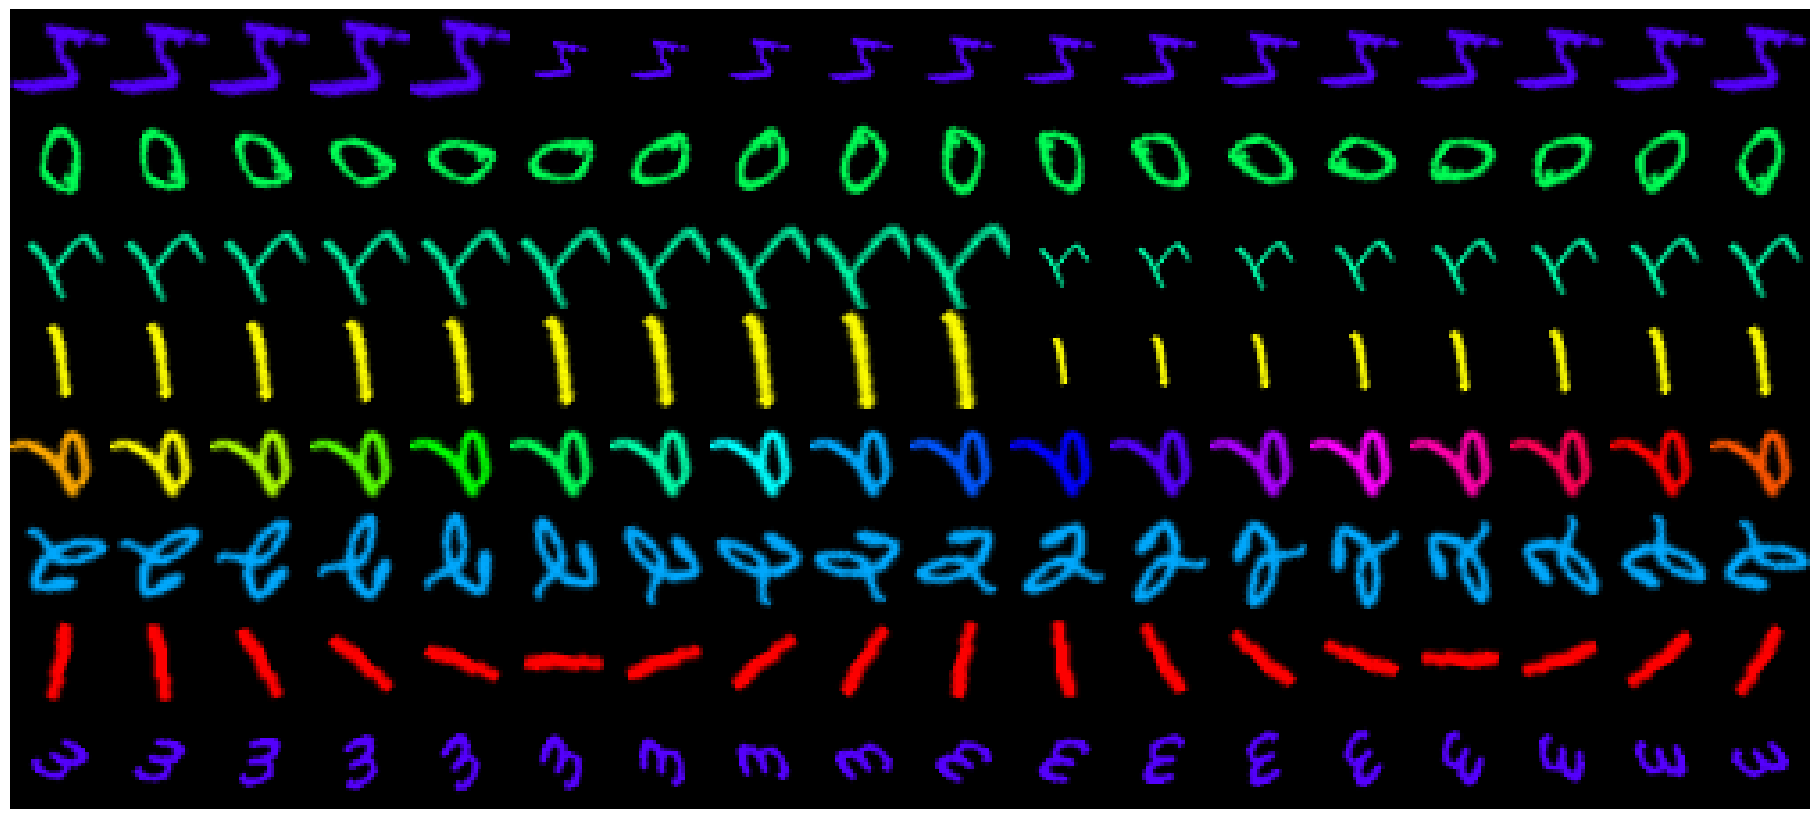

In [8]:
im, l = next(iter(train_loader))

import matplotlib.pyplot as plt
import torch
import numpy as np


fig, axes = plt.subplots(nrows=8, ncols=18, figsize=(18, 8))

for i in range(8):
    for j in range(18):
        axes[i][j].imshow(np.moveaxis(im[i, j].cpu().squeeze(0).squeeze(0).numpy(), 0, 2), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [11]:
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
import torch.nn as nn


### Define paper encoder network
class VAEEncoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 200)
        self.fc2 = nn.Linear(200, 200)

        self.embedding = nn.Linear(200, self.latent_dim)
        self.log_var = nn.Linear(200, self.latent_dim)
        #self.context = nn.Linear(200, self.context_dim)

    def forward(self, x):
        output = ModelOutput()

        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        #output["context"] = self.context(out)

        return output

### Define paper decoder network
class VAEDecoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output



### Define paper encoder network
class TimeEncoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.context_dim = args.context_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 500)
        self.fc2 = nn.Linear(500, 200)

        #self.time_fc1 = nn.Linear(1, 50)
        #self.time_fc2 = nn.Linear(50, 50)

        self.embedding = nn.Linear(200, self.latent_dim)
        self.log_var = nn.Linear(200, self.latent_dim)
        #self.context = nn.Linear(250, self.context_dim)

    def forward(self, x, t=None):
        output = ModelOutput()

        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))

        #time_out = torch.relu(self.time_fc1(t))
        #time_out = torch.relu(self.time_fc2(time_out))
        #out = torch.cat((out, time_out), dim=-1)

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        #output["context"] = self.context(out)

        return output

### Define paper decoder network
class TimeDecoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim+1, 500)
        self.fc2 = nn.Linear(500, 200)

        #self.time_fc1 = nn.Linear(1, 50)
        #self.time_fc2 = nn.Linear(50, 50)

        self.fc3 = nn.Linear(200, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor, t=None):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))

        #time_out = torch.relu(self.time_fc1(t))
        #time_out = torch.relu(self.time_fc2(time_out))
        #out = torch.cat((out, time_out), dim=-1)

        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output


### Define paper encoder network
class Encoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.context_dim = args.context_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 500)
        self.fc2 = nn.Linear(500, 200)

        self.embedding = nn.Linear(200, self.latent_dim)
        self.log_var = nn.Linear(200, self.latent_dim)
        self.context = nn.Linear(200, self.context_dim)

    def forward(self, x):
        output = ModelOutput()

        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        output["context"] = self.context(out)

        return output

### Define paper decoder network
class Decoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 500)
        self.fc2 = nn.Linear(500, 200)


        self.fc3 = nn.Linear(200, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))

        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output



## VAE

## CVAE

In [17]:
from pythae.models import LCVAE, LCVAE_Config
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim


config = LCVAE_Config(
    input_dim=(1, 28, 28),
    latent_dim=2,
    n_obs_per_ind=8
)

encoder = TimeEncoder(config)
decoder = TimeDecoder(config)

vae = LCVAE(config, encoder, decoder).cuda()


#train_dataset = DynBinarizedMNIST(train_data.reshape(-1, 8, 784))
#eval_dataset = DynBinarizedMNIST(eval_data.reshape(-1, 8, 784))

training_config = BaseTrainerConfig(
    num_epochs=1000,
    learning_rate=1e-3,
    batch_size=100
)

### Optimizer
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
vae_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    vae_optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

vae_trainer = BaseTrainer(
        model=vae,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        training_config=training_config,
        optimizer=vae_optimizer,
        scheduler=vae_scheduler,
        callbacks=None,
    )

NameError: name 'DynBinarizedMNIST' is not defined

In [105]:
_ = vae({'data': train_data[:5].cuda().reshape((-1, 8, 28*28)).float()}, epoch=0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x785 and 784x500)

In [95]:
vae_trainer.train()

Model passed sanity check !

Created dummy_output_dir/VAE_IAF_training_2022-10-14_20-37-00. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/1000: 100%|██████████| 100/100 [00:00<00:00, 148.78batch/s]
--------------------------------------------------------------------------
Train loss: 66.2867
Eval loss: 54.5661
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 2/1000: 100%|██████████| 100/100 [00:00<00:00, 248.69batch/s]
--------------------------------------------------------------------------
Train loss: 53.9584
Eval loss: 52.1471
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 3/1000: 100%|██████████| 100/100 [00:00<00:00, 228.49batch/s]
--------------------------------------------------------------------------
Train loss: 50.6103
Eval loss: 48.8062
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 4/1000: 100%|██████████| 100/100 [00:00<00:00, 487.99batch/s]
--------------------------------------------------------------------------
Train loss: 48.0907
Eval loss: 47.2235
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 5/1000: 100%|██████████| 100/100 [00:00<00:00, 541.20batch/s]
--------------------------------------------------------------------------
Train loss: 46.9568
Eval loss: 46.4951
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 6/1000: 100%|██████████| 100/100 [00:00<00:00, 592.35batch/s]
--------------------------------------------------------------------------
Train loss: 46.3333
Eval loss: 46.0488
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 7/1000: 100%|██████████| 100/100 [00:00<00:00, 581.25batch/s]
--------------------------------------------------------------------------
Train loss: 45.9495
Eval loss: 45.6813
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 8/1000: 100%|██████████| 100/100 [00:00<00:00, 592.53batch/s]
--------------------------------------------------------------------------
Train loss: 45.6239
Eval loss: 45.3713
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 9/1000: 100%|██████████| 100/100 [00:00<00:00, 537.67batch/s]
--------------------------------------------------------------------------
Train loss: 45.322
Eval loss: 45.0523
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 10/1000: 100%|██████████| 100/100 [00:00<00:00, 603.12batch/s]
--------------------------------------------------------------------------
Train loss: 45.0797
Eval loss: 44.7829
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 11/1000: 100%|██████████| 100/100 [00:00<00:00, 574.82batch/s]
--------------------------------------------------------------------------
Train loss: 44.8088
Eval loss: 44.6812
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 12/1000: 100%|██████████| 100/100 [00:00<00:00, 600.90batch/s]
--------------------------------------------------------------------------
Train loss: 44.5711
Eval loss: 44.3317
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 13/1000: 100%|██████████| 100/100 [00:00<00:00, 576.11batch/s]
--------------------------------------------------------------------------
Train loss: 44.3178
Eval loss: 44.1058
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 14/1000: 100%|██████████| 100/100 [00:00<00:00, 610.52batch/s]
--------------------------------------------------------------------------
Train loss: 44.0575
Eval loss: 43.8706
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 15/1000: 100%|██████████| 100/100 [00:00<00:00, 596.90batch/s]
--------------------------------------------------------------------------
Train loss: 43.7843
Eval loss: 43.5614
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 16/1000: 100%|██████████| 100/100 [00:00<00:00, 555.02batch/s]
--------------------------------------------------------------------------
Train loss: 43.5231
Eval loss: 43.3381
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 17/1000: 100%|██████████| 100/100 [00:00<00:00, 460.65batch/s]
--------------------------------------------------------------------------
Train loss: 43.2861
Eval loss: 43.2369
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 18/1000: 100%|██████████| 100/100 [00:00<00:00, 608.97batch/s]
--------------------------------------------------------------------------
Train loss: 43.1073
Eval loss: 42.9602
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 19/1000: 100%|██████████| 100/100 [00:00<00:00, 419.93batch/s]
--------------------------------------------------------------------------
Train loss: 42.8446
Eval loss: 42.7575
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 20/1000: 100%|██████████| 100/100 [00:00<00:00, 557.62batch/s]
--------------------------------------------------------------------------
Train loss: 42.6423
Eval loss: 42.5842
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 21/1000: 100%|██████████| 100/100 [00:00<00:00, 525.32batch/s]
--------------------------------------------------------------------------
Train loss: 42.4253
Eval loss: 42.401
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 22/1000: 100%|██████████| 100/100 [00:00<00:00, 496.66batch/s]
--------------------------------------------------------------------------
Train loss: 42.267
Eval loss: 42.2775
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 23/1000: 100%|██████████| 100/100 [00:00<00:00, 604.69batch/s]
--------------------------------------------------------------------------
Train loss: 42.0679
Eval loss: 42.198
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 24/1000: 100%|██████████| 100/100 [00:00<00:00, 490.39batch/s]
--------------------------------------------------------------------------
Train loss: 41.9188
Eval loss: 41.9735
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 25/1000: 100%|██████████| 100/100 [00:00<00:00, 529.48batch/s]
--------------------------------------------------------------------------
Train loss: 41.7784
Eval loss: 41.8443
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 26/1000: 100%|██████████| 100/100 [00:00<00:00, 611.72batch/s]
--------------------------------------------------------------------------
Train loss: 41.6499
Eval loss: 41.8314
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 27/1000: 100%|██████████| 100/100 [00:00<00:00, 604.65batch/s]
--------------------------------------------------------------------------
Train loss: 41.4882
Eval loss: 41.6955
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 28/1000: 100%|██████████| 100/100 [00:00<00:00, 602.92batch/s]
--------------------------------------------------------------------------
Train loss: 41.3548
Eval loss: 41.6582
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 29/1000: 100%|██████████| 100/100 [00:00<00:00, 576.45batch/s]
--------------------------------------------------------------------------
Train loss: 41.2621
Eval loss: 41.6436
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 30/1000: 100%|██████████| 100/100 [00:00<00:00, 604.96batch/s]
--------------------------------------------------------------------------
Train loss: 41.1255
Eval loss: 41.346
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 31/1000: 100%|██████████| 100/100 [00:00<00:00, 686.60batch/s]
--------------------------------------------------------------------------
Train loss: 41.0161
Eval loss: 41.3931
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 32/1000: 100%|██████████| 100/100 [00:00<00:00, 600.92batch/s]
--------------------------------------------------------------------------
Train loss: 40.9014
Eval loss: 41.3503
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 33/1000: 100%|██████████| 100/100 [00:00<00:00, 605.57batch/s]
--------------------------------------------------------------------------
Train loss: 40.801
Eval loss: 41.1527
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 34/1000: 100%|██████████| 100/100 [00:00<00:00, 613.23batch/s]
--------------------------------------------------------------------------
Train loss: 40.6698
Eval loss: 41.1135
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 35/1000: 100%|██████████| 100/100 [00:00<00:00, 601.23batch/s]
--------------------------------------------------------------------------
Train loss: 40.5515
Eval loss: 41.0479
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 36/1000: 100%|██████████| 100/100 [00:00<00:00, 592.10batch/s]
--------------------------------------------------------------------------
Train loss: 40.4781
Eval loss: 40.9838
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 37/1000: 100%|██████████| 100/100 [00:00<00:00, 570.20batch/s]
--------------------------------------------------------------------------
Train loss: 40.3828
Eval loss: 41.0172
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 38/1000: 100%|██████████| 100/100 [00:00<00:00, 531.55batch/s]
--------------------------------------------------------------------------
Train loss: 40.2697
Eval loss: 40.8755
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 39/1000: 100%|██████████| 100/100 [00:00<00:00, 601.55batch/s]
--------------------------------------------------------------------------
Train loss: 40.1952
Eval loss: 40.732
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 40/1000: 100%|██████████| 100/100 [00:00<00:00, 587.37batch/s]
--------------------------------------------------------------------------
Train loss: 40.1167
Eval loss: 40.7372
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 41/1000: 100%|██████████| 100/100 [00:00<00:00, 543.61batch/s]
--------------------------------------------------------------------------
Train loss: 40.0199
Eval loss: 40.6468
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 42/1000: 100%|██████████| 100/100 [00:00<00:00, 557.26batch/s]
--------------------------------------------------------------------------
Train loss: 39.9499
Eval loss: 40.6374
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 43/1000: 100%|██████████| 100/100 [00:00<00:00, 532.61batch/s]
--------------------------------------------------------------------------
Train loss: 39.8607
Eval loss: 40.6132
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 44/1000: 100%|██████████| 100/100 [00:00<00:00, 568.08batch/s]
--------------------------------------------------------------------------
Train loss: 39.8096
Eval loss: 40.5773
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 45/1000: 100%|██████████| 100/100 [00:00<00:00, 372.61batch/s]
--------------------------------------------------------------------------
Train loss: 39.7311
Eval loss: 40.4793
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 46/1000: 100%|██████████| 100/100 [00:00<00:00, 599.11batch/s]
--------------------------------------------------------------------------
Train loss: 39.6981
Eval loss: 40.5377
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 47/1000: 100%|██████████| 100/100 [00:00<00:00, 563.93batch/s]
--------------------------------------------------------------------------
Train loss: 39.614
Eval loss: 40.3749
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 48/1000: 100%|██████████| 100/100 [00:00<00:00, 532.47batch/s]
--------------------------------------------------------------------------
Train loss: 39.5085
Eval loss: 40.3212
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 49/1000: 100%|██████████| 100/100 [00:00<00:00, 611.85batch/s]
--------------------------------------------------------------------------
Train loss: 39.4613
Eval loss: 40.323
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 50/1000: 100%|██████████| 100/100 [00:00<00:00, 523.46batch/s]
--------------------------------------------------------------------------
Train loss: 39.3972
Eval loss: 40.3172
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 51/1000: 100%|██████████| 100/100 [00:00<00:00, 605.59batch/s]
--------------------------------------------------------------------------
Train loss: 39.3514
Eval loss: 40.3541
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 52/1000: 100%|██████████| 100/100 [00:00<00:00, 543.51batch/s]
--------------------------------------------------------------------------
Train loss: 39.2645
Eval loss: 40.2709
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 53/1000: 100%|██████████| 100/100 [00:00<00:00, 598.45batch/s]
--------------------------------------------------------------------------
Train loss: 39.2275
Eval loss: 40.1878
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 54/1000: 100%|██████████| 100/100 [00:00<00:00, 527.65batch/s]
--------------------------------------------------------------------------
Train loss: 39.1777
Eval loss: 40.1785
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 55/1000: 100%|██████████| 100/100 [00:00<00:00, 597.03batch/s]
--------------------------------------------------------------------------
Train loss: 39.0825
Eval loss: 40.176
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 56/1000: 100%|██████████| 100/100 [00:00<00:00, 556.69batch/s]
--------------------------------------------------------------------------
Train loss: 39.0728
Eval loss: 40.0822
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 57/1000: 100%|██████████| 100/100 [00:00<00:00, 632.98batch/s]
--------------------------------------------------------------------------
Train loss: 39.0307
Eval loss: 40.1457
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 58/1000: 100%|██████████| 100/100 [00:00<00:00, 524.81batch/s]
--------------------------------------------------------------------------
Train loss: 38.9705
Eval loss: 40.013
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 59/1000: 100%|██████████| 100/100 [00:00<00:00, 460.91batch/s]
--------------------------------------------------------------------------
Train loss: 38.9259
Eval loss: 40.202
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 60/1000: 100%|██████████| 100/100 [00:00<00:00, 623.49batch/s]
--------------------------------------------------------------------------
Train loss: 38.8841
Eval loss: 40.0577
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 61/1000: 100%|██████████| 100/100 [00:00<00:00, 563.91batch/s]
--------------------------------------------------------------------------
Train loss: 38.818
Eval loss: 39.9421
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 62/1000: 100%|██████████| 100/100 [00:00<00:00, 543.40batch/s]
--------------------------------------------------------------------------
Train loss: 38.7559
Eval loss: 39.9113
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 63/1000: 100%|██████████| 100/100 [00:00<00:00, 660.63batch/s]
--------------------------------------------------------------------------
Train loss: 38.724
Eval loss: 39.9465
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 64/1000:  86%|████████▌ | 86/100 [00:00<00:00, 202.28batch/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 64/1000: 100%|██████████| 100/100 [00:00<00:00, 226.97batch/s]
--------------------------------------------------------------------------
Train loss: 38.705
Eval loss: 39.8475
--------------------------------------------------------------------------
Eval of epoch 65/1000: 100%|██████████| 100/100 [00:00<00:00, 433.63batch/s]
--------------------------------------------------------------------------
Train loss: 38.6407
Eval loss: 39.8291
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 66/1000: 100%|██████████| 100/100 [00:00<00:00, 306.55batch/s]
--------------------------------------------------------------------------
Train loss: 38.5896
Eval loss: 39.8193
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 67/1000: 100%|██████████| 100/100 [00:00<00:00, 561.43batch/s]
--------------------------------------------------------------------------
Train loss: 38.5533
Eval loss: 39.8181
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 68/1000: 100%|██████████| 100/100 [00:00<00:00, 534.82batch/s]
--------------------------------------------------------------------------
Train loss: 38.5224
Eval loss: 39.7428
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 69/1000: 100%|██████████| 100/100 [00:00<00:00, 510.23batch/s]
--------------------------------------------------------------------------
Train loss: 38.4673
Eval loss: 39.7607
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 70/1000: 100%|██████████| 100/100 [00:00<00:00, 543.21batch/s]
--------------------------------------------------------------------------
Train loss: 38.4428
Eval loss: 39.7837
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 71/1000: 100%|██████████| 100/100 [00:00<00:00, 491.98batch/s]
--------------------------------------------------------------------------
Train loss: 38.4092
Eval loss: 39.7398
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 72/1000: 100%|██████████| 100/100 [00:00<00:00, 398.27batch/s]
--------------------------------------------------------------------------
Train loss: 38.3527
Eval loss: 39.6753
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 73/1000: 100%|██████████| 100/100 [00:00<00:00, 573.45batch/s]
--------------------------------------------------------------------------
Train loss: 38.3476
Eval loss: 39.7005
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 74/1000: 100%|██████████| 100/100 [00:00<00:00, 581.07batch/s]
--------------------------------------------------------------------------
Train loss: 38.3244
Eval loss: 39.7131
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 75/1000: 100%|██████████| 100/100 [00:00<00:00, 384.32batch/s]
--------------------------------------------------------------------------
Train loss: 38.2773
Eval loss: 39.6502
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 76/1000: 100%|██████████| 100/100 [00:00<00:00, 488.20batch/s]
--------------------------------------------------------------------------
Train loss: 38.2423
Eval loss: 39.6333
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 77/1000: 100%|██████████| 100/100 [00:00<00:00, 540.48batch/s]
--------------------------------------------------------------------------
Train loss: 38.2061
Eval loss: 39.6244
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 78/1000: 100%|██████████| 100/100 [00:00<00:00, 502.40batch/s]
--------------------------------------------------------------------------
Train loss: 38.1902
Eval loss: 39.6228
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 79/1000: 100%|██████████| 100/100 [00:00<00:00, 519.15batch/s]
--------------------------------------------------------------------------
Train loss: 38.1616
Eval loss: 39.6305
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 80/1000: 100%|██████████| 100/100 [00:00<00:00, 616.44batch/s]
--------------------------------------------------------------------------
Train loss: 38.1127
Eval loss: 39.7649
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 81/1000: 100%|██████████| 100/100 [00:00<00:00, 497.07batch/s]
--------------------------------------------------------------------------
Train loss: 38.0834
Eval loss: 39.6636
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 82/1000: 100%|██████████| 100/100 [00:00<00:00, 556.90batch/s]
--------------------------------------------------------------------------
Train loss: 38.1053
Eval loss: 39.5462
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 83/1000: 100%|██████████| 100/100 [00:00<00:00, 630.07batch/s]
--------------------------------------------------------------------------
Train loss: 38.042
Eval loss: 39.5983
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 84/1000: 100%|██████████| 100/100 [00:00<00:00, 518.82batch/s]
--------------------------------------------------------------------------
Train loss: 37.9933
Eval loss: 39.552
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 85/1000: 100%|██████████| 100/100 [00:00<00:00, 483.73batch/s]
--------------------------------------------------------------------------
Train loss: 37.9945
Eval loss: 39.5313
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 86/1000: 100%|██████████| 100/100 [00:00<00:00, 513.08batch/s]
--------------------------------------------------------------------------
Train loss: 37.9699
Eval loss: 39.4871
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 87/1000: 100%|██████████| 100/100 [00:00<00:00, 462.91batch/s]
--------------------------------------------------------------------------
Train loss: 37.9467
Eval loss: 39.4793
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 88/1000: 100%|██████████| 100/100 [00:00<00:00, 591.28batch/s]
--------------------------------------------------------------------------
Train loss: 37.8974
Eval loss: 39.4078
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 89/1000: 100%|██████████| 100/100 [00:00<00:00, 566.46batch/s]
--------------------------------------------------------------------------
Train loss: 37.8486
Eval loss: 39.4689
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 90/1000: 100%|██████████| 100/100 [00:00<00:00, 592.41batch/s]
--------------------------------------------------------------------------
Train loss: 37.8488
Eval loss: 39.4462
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 91/1000: 100%|██████████| 100/100 [00:00<00:00, 652.06batch/s]
--------------------------------------------------------------------------
Train loss: 37.8122
Eval loss: 39.4611
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 92/1000: 100%|██████████| 100/100 [00:00<00:00, 622.69batch/s]
--------------------------------------------------------------------------
Train loss: 37.8536
Eval loss: 39.4752
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 93/1000: 100%|██████████| 100/100 [00:00<00:00, 613.62batch/s]
--------------------------------------------------------------------------
Train loss: 37.7652
Eval loss: 39.4921
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 94/1000: 100%|██████████| 100/100 [00:00<00:00, 586.96batch/s]
--------------------------------------------------------------------------
Train loss: 37.7477
Eval loss: 39.3858
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 95/1000: 100%|██████████| 100/100 [00:00<00:00, 651.73batch/s]
--------------------------------------------------------------------------
Train loss: 37.7468
Eval loss: 39.4415
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 96/1000: 100%|██████████| 100/100 [00:00<00:00, 583.38batch/s]
--------------------------------------------------------------------------
Train loss: 37.7032
Eval loss: 39.4418
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 97/1000: 100%|██████████| 100/100 [00:00<00:00, 570.85batch/s]
--------------------------------------------------------------------------
Train loss: 37.6618
Eval loss: 39.3726
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 98/1000: 100%|██████████| 100/100 [00:00<00:00, 668.42batch/s]
--------------------------------------------------------------------------
Train loss: 37.6621
Eval loss: 39.484
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 99/1000: 100%|██████████| 100/100 [00:00<00:00, 543.56batch/s]
--------------------------------------------------------------------------
Train loss: 37.6538
Eval loss: 39.3675
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 100/1000: 100%|██████████| 100/100 [00:00<00:00, 602.46batch/s]
--------------------------------------------------------------------------
Train loss: 37.6318
Eval loss: 39.404
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 101/1000: 100%|██████████| 100/100 [00:00<00:00, 525.85batch/s]
--------------------------------------------------------------------------
Train loss: 37.6166
Eval loss: 39.4004
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 102/1000: 100%|██████████| 100/100 [00:00<00:00, 622.77batch/s]
--------------------------------------------------------------------------
Train loss: 37.5667
Eval loss: 39.4101
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 103/1000: 100%|██████████| 100/100 [00:00<00:00, 573.70batch/s]
--------------------------------------------------------------------------
Train loss: 37.5805
Eval loss: 39.3638
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 104/1000: 100%|██████████| 100/100 [00:00<00:00, 572.67batch/s]
--------------------------------------------------------------------------
Train loss: 37.5627
Eval loss: 39.381
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 105/1000: 100%|██████████| 100/100 [00:00<00:00, 605.77batch/s]
--------------------------------------------------------------------------
Train loss: 37.5089
Eval loss: 39.3121
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 106/1000: 100%|██████████| 100/100 [00:00<00:00, 648.20batch/s]
--------------------------------------------------------------------------
Train loss: 37.5014
Eval loss: 39.3212
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 107/1000: 100%|██████████| 100/100 [00:00<00:00, 643.60batch/s]
--------------------------------------------------------------------------
Train loss: 37.4757
Eval loss: 39.3465
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 108/1000: 100%|██████████| 100/100 [00:00<00:00, 643.90batch/s]
--------------------------------------------------------------------------
Train loss: 37.4701
Eval loss: 39.3373
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 109/1000: 100%|██████████| 100/100 [00:00<00:00, 597.35batch/s]
--------------------------------------------------------------------------
Train loss: 37.4182
Eval loss: 39.2219
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 110/1000: 100%|██████████| 100/100 [00:00<00:00, 622.50batch/s]
--------------------------------------------------------------------------
Train loss: 37.4409
Eval loss: 39.3282
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 111/1000: 100%|██████████| 100/100 [00:00<00:00, 675.63batch/s]
--------------------------------------------------------------------------
Train loss: 37.4344
Eval loss: 39.3241
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 112/1000: 100%|██████████| 100/100 [00:00<00:00, 578.66batch/s]
--------------------------------------------------------------------------
Train loss: 37.3958
Eval loss: 39.19
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 113/1000: 100%|██████████| 100/100 [00:00<00:00, 404.13batch/s]
--------------------------------------------------------------------------
Train loss: 37.3631
Eval loss: 39.2938
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 114/1000: 100%|██████████| 100/100 [00:00<00:00, 669.54batch/s]
--------------------------------------------------------------------------
Train loss: 37.3381
Eval loss: 39.2647
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 115/1000: 100%|██████████| 100/100 [00:00<00:00, 586.98batch/s]
--------------------------------------------------------------------------
Train loss: 37.3365
Eval loss: 39.2344
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 116/1000: 100%|██████████| 100/100 [00:00<00:00, 606.56batch/s]
--------------------------------------------------------------------------
Train loss: 37.2874
Eval loss: 39.2651
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 117/1000: 100%|██████████| 100/100 [00:00<00:00, 488.04batch/s]
--------------------------------------------------------------------------
Train loss: 37.2826
Eval loss: 39.3628
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 118/1000: 100%|██████████| 100/100 [00:00<00:00, 608.92batch/s]
--------------------------------------------------------------------------
Train loss: 37.3011
Eval loss: 39.3698
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 119/1000: 100%|██████████| 100/100 [00:00<00:00, 583.70batch/s]
--------------------------------------------------------------------------
Train loss: 37.2765
Eval loss: 39.2215
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 120/1000: 100%|██████████| 100/100 [00:00<00:00, 604.45batch/s]
--------------------------------------------------------------------------
Train loss: 37.2576
Eval loss: 39.2082
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 121/1000: 100%|██████████| 100/100 [00:00<00:00, 551.15batch/s]
--------------------------------------------------------------------------
Train loss: 37.2337
Eval loss: 39.1781
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 122/1000: 100%|██████████| 100/100 [00:00<00:00, 448.77batch/s]
--------------------------------------------------------------------------
Train loss: 37.1997
Eval loss: 39.1618
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 123/1000: 100%|██████████| 100/100 [00:00<00:00, 438.96batch/s]
--------------------------------------------------------------------------
Train loss: 37.2052
Eval loss: 39.235
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 124/1000: 100%|██████████| 100/100 [00:00<00:00, 676.20batch/s]
--------------------------------------------------------------------------
Train loss: 37.1561
Eval loss: 39.3048
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 125/1000: 100%|██████████| 100/100 [00:00<00:00, 587.45batch/s]
--------------------------------------------------------------------------
Train loss: 37.1834
Eval loss: 39.1867
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 126/1000: 100%|██████████| 100/100 [00:00<00:00, 517.31batch/s]
--------------------------------------------------------------------------
Train loss: 37.1409
Eval loss: 39.1806
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 127/1000: 100%|██████████| 100/100 [00:00<00:00, 680.91batch/s]
--------------------------------------------------------------------------
Train loss: 37.1379
Eval loss: 39.2542
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 128/1000: 100%|██████████| 100/100 [00:00<00:00, 608.24batch/s]
--------------------------------------------------------------------------
Train loss: 37.162
Eval loss: 39.2992
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 129/1000: 100%|██████████| 100/100 [00:00<00:00, 677.95batch/s]
--------------------------------------------------------------------------
Train loss: 37.1551
Eval loss: 39.267
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 130/1000: 100%|██████████| 100/100 [00:00<00:00, 596.78batch/s]
--------------------------------------------------------------------------
Train loss: 37.1109
Eval loss: 39.3469
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 131/1000: 100%|██████████| 100/100 [00:00<00:00, 625.25batch/s]
--------------------------------------------------------------------------
Train loss: 37.0865
Eval loss: 39.184
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 132/1000: 100%|██████████| 100/100 [00:00<00:00, 688.71batch/s]
--------------------------------------------------------------------------
Train loss: 37.0771
Eval loss: 39.2407
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 133/1000: 100%|██████████| 100/100 [00:00<00:00, 670.38batch/s]
--------------------------------------------------------------------------
Train loss: 37.0566
Eval loss: 39.2006
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 134/1000: 100%|██████████| 100/100 [00:00<00:00, 617.64batch/s]
--------------------------------------------------------------------------
Train loss: 37.0383
Eval loss: 39.3312
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 135/1000: 100%|██████████| 100/100 [00:00<00:00, 610.75batch/s]
--------------------------------------------------------------------------
Train loss: 37.0425
Eval loss: 39.12
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 136/1000: 100%|██████████| 100/100 [00:00<00:00, 644.79batch/s]
--------------------------------------------------------------------------
Train loss: 37.0439
Eval loss: 39.1475
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 137/1000: 100%|██████████| 100/100 [00:00<00:00, 528.56batch/s]
--------------------------------------------------------------------------
Train loss: 36.9981
Eval loss: 39.1605
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 138/1000: 100%|██████████| 100/100 [00:00<00:00, 584.07batch/s]
--------------------------------------------------------------------------
Train loss: 37.018
Eval loss: 39.1631
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 139/1000: 100%|██████████| 100/100 [00:00<00:00, 574.11batch/s]
--------------------------------------------------------------------------
Train loss: 36.9638
Eval loss: 39.1676
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 140/1000: 100%|██████████| 100/100 [00:00<00:00, 594.68batch/s]
--------------------------------------------------------------------------
Train loss: 36.9882
Eval loss: 39.1491
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 141/1000: 100%|██████████| 100/100 [00:00<00:00, 632.86batch/s]
--------------------------------------------------------------------------
Train loss: 36.9424
Eval loss: 39.1504
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 142/1000: 100%|██████████| 100/100 [00:00<00:00, 524.81batch/s]
--------------------------------------------------------------------------
Train loss: 36.948
Eval loss: 39.0957
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 143/1000: 100%|██████████| 100/100 [00:00<00:00, 528.33batch/s]
--------------------------------------------------------------------------
Train loss: 36.9143
Eval loss: 39.1403
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 144/1000: 100%|██████████| 100/100 [00:00<00:00, 630.55batch/s]
--------------------------------------------------------------------------
Train loss: 36.9267
Eval loss: 39.2291
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 145/1000: 100%|██████████| 100/100 [00:00<00:00, 542.27batch/s]
--------------------------------------------------------------------------
Train loss: 36.9025
Eval loss: 39.0916
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 146/1000: 100%|██████████| 100/100 [00:00<00:00, 581.22batch/s]
--------------------------------------------------------------------------
Train loss: 36.9077
Eval loss: 39.1413
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 147/1000: 100%|██████████| 100/100 [00:00<00:00, 603.09batch/s]
--------------------------------------------------------------------------
Train loss: 36.8824
Eval loss: 39.1231
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 148/1000: 100%|██████████| 100/100 [00:00<00:00, 607.60batch/s]
--------------------------------------------------------------------------
Train loss: 36.8688
Eval loss: 39.1121
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 149/1000: 100%|██████████| 100/100 [00:00<00:00, 562.02batch/s]
--------------------------------------------------------------------------
Train loss: 36.8802
Eval loss: 39.1538
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 150/1000: 100%|██████████| 100/100 [00:00<00:00, 614.64batch/s]
--------------------------------------------------------------------------
Train loss: 36.8583
Eval loss: 39.1005
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 151/1000: 100%|██████████| 100/100 [00:00<00:00, 587.11batch/s]
--------------------------------------------------------------------------
Train loss: 36.8161
Eval loss: 39.1633
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 152/1000: 100%|██████████| 100/100 [00:00<00:00, 615.64batch/s]
--------------------------------------------------------------------------
Train loss: 36.804
Eval loss: 39.1347
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 153/1000: 100%|██████████| 100/100 [00:00<00:00, 641.03batch/s]
--------------------------------------------------------------------------
Train loss: 36.799
Eval loss: 39.1118
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 154/1000: 100%|██████████| 100/100 [00:00<00:00, 631.76batch/s]
--------------------------------------------------------------------------
Train loss: 36.7969
Eval loss: 39.1668
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 155/1000: 100%|██████████| 100/100 [00:00<00:00, 537.89batch/s]
--------------------------------------------------------------------------
Train loss: 36.7756
Eval loss: 39.0673
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 156/1000: 100%|██████████| 100/100 [00:00<00:00, 553.89batch/s]
--------------------------------------------------------------------------
Train loss: 36.7712
Eval loss: 39.0624
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 157/1000: 100%|██████████| 100/100 [00:00<00:00, 609.34batch/s]
--------------------------------------------------------------------------
Train loss: 36.7681
Eval loss: 39.1504
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 158/1000: 100%|██████████| 100/100 [00:00<00:00, 609.65batch/s]
--------------------------------------------------------------------------
Train loss: 36.7776
Eval loss: 39.1892
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 159/1000: 100%|██████████| 100/100 [00:00<00:00, 607.82batch/s]
--------------------------------------------------------------------------
Train loss: 36.7967
Eval loss: 39.1907
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 160/1000: 100%|██████████| 100/100 [00:00<00:00, 537.71batch/s]
--------------------------------------------------------------------------
Train loss: 36.739
Eval loss: 39.0604
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 161/1000: 100%|██████████| 100/100 [00:00<00:00, 635.69batch/s]
--------------------------------------------------------------------------
Train loss: 36.7055
Eval loss: 39.0776
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 162/1000: 100%|██████████| 100/100 [00:00<00:00, 548.36batch/s]
--------------------------------------------------------------------------
Train loss: 36.7134
Eval loss: 39.1808
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 163/1000: 100%|██████████| 100/100 [00:00<00:00, 666.13batch/s]
--------------------------------------------------------------------------
Train loss: 36.6973
Eval loss: 39.2454
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 164/1000: 100%|██████████| 100/100 [00:00<00:00, 631.47batch/s]
--------------------------------------------------------------------------
Train loss: 36.7333
Eval loss: 39.1423
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 165/1000: 100%|██████████| 100/100 [00:00<00:00, 613.45batch/s]
--------------------------------------------------------------------------
Train loss: 36.7062
Eval loss: 39.0663
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 166/1000: 100%|██████████| 100/100 [00:00<00:00, 629.39batch/s]
--------------------------------------------------------------------------
Train loss: 36.6757
Eval loss: 39.1244
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 167/1000: 100%|██████████| 100/100 [00:00<00:00, 636.23batch/s]
--------------------------------------------------------------------------
Train loss: 36.6926
Eval loss: 39.0749
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 168/1000: 100%|██████████| 100/100 [00:00<00:00, 507.53batch/s]
--------------------------------------------------------------------------
Train loss: 36.6344
Eval loss: 39.042
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 169/1000: 100%|██████████| 100/100 [00:00<00:00, 528.08batch/s]
--------------------------------------------------------------------------
Train loss: 36.6433
Eval loss: 39.1071
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 170/1000: 100%|██████████| 100/100 [00:00<00:00, 591.27batch/s]
--------------------------------------------------------------------------
Train loss: 36.6663
Eval loss: 39.192
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 171/1000: 100%|██████████| 100/100 [00:00<00:00, 521.35batch/s]
--------------------------------------------------------------------------
Train loss: 36.6315
Eval loss: 39.0044
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 172/1000: 100%|██████████| 100/100 [00:00<00:00, 616.43batch/s]
--------------------------------------------------------------------------
Train loss: 36.5919
Eval loss: 39.0762
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 173/1000: 100%|██████████| 100/100 [00:00<00:00, 680.90batch/s]
--------------------------------------------------------------------------
Train loss: 36.6083
Eval loss: 39.106
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 174/1000: 100%|██████████| 100/100 [00:00<00:00, 548.91batch/s]
--------------------------------------------------------------------------
Train loss: 36.5823
Eval loss: 39.0003
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 175/1000: 100%|██████████| 100/100 [00:00<00:00, 553.76batch/s]
--------------------------------------------------------------------------
Train loss: 36.5915
Eval loss: 39.2789
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 176/1000: 100%|██████████| 100/100 [00:00<00:00, 611.22batch/s]
--------------------------------------------------------------------------
Train loss: 36.5836
Eval loss: 39.0342
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 177/1000: 100%|██████████| 100/100 [00:00<00:00, 452.40batch/s]
--------------------------------------------------------------------------
Train loss: 36.5534
Eval loss: 39.0129
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 178/1000: 100%|██████████| 100/100 [00:00<00:00, 562.51batch/s]
--------------------------------------------------------------------------
Train loss: 36.5568
Eval loss: 39.1578
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 179/1000: 100%|██████████| 100/100 [00:00<00:00, 480.73batch/s]
--------------------------------------------------------------------------
Train loss: 36.5704
Eval loss: 39.0793
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 180/1000: 100%|██████████| 100/100 [00:00<00:00, 592.05batch/s]
--------------------------------------------------------------------------
Train loss: 36.5369
Eval loss: 39.0981
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 181/1000: 100%|██████████| 100/100 [00:00<00:00, 587.18batch/s]
--------------------------------------------------------------------------
Train loss: 36.5309
Eval loss: 39.1465
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 182/1000: 100%|██████████| 100/100 [00:00<00:00, 630.34batch/s]
--------------------------------------------------------------------------
Train loss: 36.5268
Eval loss: 39.0616
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 183/1000: 100%|██████████| 100/100 [00:00<00:00, 476.52batch/s]
--------------------------------------------------------------------------
Train loss: 36.5141
Eval loss: 39.0782
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 184/1000: 100%|██████████| 100/100 [00:00<00:00, 584.53batch/s]
--------------------------------------------------------------------------
Train loss: 36.508
Eval loss: 39.0441
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 185/1000: 100%|██████████| 100/100 [00:00<00:00, 598.36batch/s]
--------------------------------------------------------------------------
Train loss: 36.5132
Eval loss: 39.069
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 186/1000: 100%|██████████| 100/100 [00:00<00:00, 558.36batch/s]
--------------------------------------------------------------------------
Train loss: 36.4687
Eval loss: 39.2319
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 187/1000: 100%|██████████| 100/100 [00:00<00:00, 451.92batch/s]
--------------------------------------------------------------------------
Train loss: 36.4865
Eval loss: 39.0921
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 188/1000: 100%|██████████| 100/100 [00:00<00:00, 572.42batch/s]
--------------------------------------------------------------------------
Train loss: 36.4807
Eval loss: 39.0964
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 189/1000: 100%|██████████| 100/100 [00:00<00:00, 583.94batch/s]
--------------------------------------------------------------------------
Train loss: 36.4527
Eval loss: 39.1273
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 190/1000: 100%|██████████| 100/100 [00:00<00:00, 556.87batch/s]
--------------------------------------------------------------------------
Train loss: 36.4637
Eval loss: 39.0659
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 191/1000: 100%|██████████| 100/100 [00:00<00:00, 570.62batch/s]
--------------------------------------------------------------------------
Train loss: 36.4336
Eval loss: 39.0212
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 192/1000: 100%|██████████| 100/100 [00:00<00:00, 594.85batch/s]
--------------------------------------------------------------------------
Train loss: 36.4296
Eval loss: 39.0509
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 193/1000: 100%|██████████| 100/100 [00:00<00:00, 575.51batch/s]
--------------------------------------------------------------------------
Train loss: 36.4415
Eval loss: 39.1014
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 194/1000: 100%|██████████| 100/100 [00:00<00:00, 566.81batch/s]
--------------------------------------------------------------------------
Train loss: 36.4395
Eval loss: 39.1282
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 195/1000: 100%|██████████| 100/100 [00:00<00:00, 599.94batch/s]
--------------------------------------------------------------------------
Train loss: 36.4088
Eval loss: 39.0441
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 196/1000: 100%|██████████| 100/100 [00:00<00:00, 543.27batch/s]
--------------------------------------------------------------------------
Train loss: 36.3989
Eval loss: 38.995
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 197/1000: 100%|██████████| 100/100 [00:00<00:00, 599.22batch/s]
--------------------------------------------------------------------------
Train loss: 36.404
Eval loss: 39.0327
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 198/1000: 100%|██████████| 100/100 [00:00<00:00, 673.10batch/s]
--------------------------------------------------------------------------
Train loss: 36.3891
Eval loss: 39.0129
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 199/1000: 100%|██████████| 100/100 [00:00<00:00, 637.73batch/s]
--------------------------------------------------------------------------
Train loss: 36.3885
Eval loss: 39.1288
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 200/1000: 100%|██████████| 100/100 [00:00<00:00, 611.05batch/s]
--------------------------------------------------------------------------
Train loss: 36.3969
Eval loss: 39.0521
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 201/1000: 100%|██████████| 100/100 [00:00<00:00, 675.39batch/s]
--------------------------------------------------------------------------
Train loss: 36.3955
Eval loss: 39.0551
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 202/1000: 100%|██████████| 100/100 [00:00<00:00, 659.90batch/s]
--------------------------------------------------------------------------
Train loss: 36.3974
Eval loss: 39.2447
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 203/1000: 100%|██████████| 100/100 [00:00<00:00, 638.95batch/s]
--------------------------------------------------------------------------
Train loss: 36.3535
Eval loss: 39.0402
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 204/1000: 100%|██████████| 100/100 [00:00<00:00, 600.59batch/s]
--------------------------------------------------------------------------
Train loss: 36.3772
Eval loss: 39.083
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 205/1000: 100%|██████████| 100/100 [00:00<00:00, 679.73batch/s]
--------------------------------------------------------------------------
Train loss: 36.3313
Eval loss: 38.9982
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 206/1000: 100%|██████████| 100/100 [00:00<00:00, 675.55batch/s]
--------------------------------------------------------------------------
Train loss: 36.3195
Eval loss: 39.0402
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 207/1000: 100%|██████████| 100/100 [00:00<00:00, 637.41batch/s]
--------------------------------------------------------------------------
Train loss: 36.3285
Eval loss: 39.1136
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 208/1000: 100%|██████████| 100/100 [00:00<00:00, 659.37batch/s]
--------------------------------------------------------------------------
Train loss: 36.3511
Eval loss: 39.155
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 209/1000: 100%|██████████| 100/100 [00:00<00:00, 623.58batch/s]
--------------------------------------------------------------------------
Train loss: 36.3172
Eval loss: 39.011
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 210/1000: 100%|██████████| 100/100 [00:00<00:00, 582.51batch/s]
--------------------------------------------------------------------------
Train loss: 36.2983
Eval loss: 39.102
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 211/1000: 100%|██████████| 100/100 [00:00<00:00, 571.77batch/s]
--------------------------------------------------------------------------
Train loss: 36.2701
Eval loss: 38.9863
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 212/1000: 100%|██████████| 100/100 [00:00<00:00, 630.20batch/s]
--------------------------------------------------------------------------
Train loss: 36.2563
Eval loss: 39.0291
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 213/1000: 100%|██████████| 100/100 [00:00<00:00, 450.67batch/s]
--------------------------------------------------------------------------
Train loss: 36.276
Eval loss: 39.0932
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 214/1000: 100%|██████████| 100/100 [00:00<00:00, 663.55batch/s]
--------------------------------------------------------------------------
Train loss: 36.2697
Eval loss: 39.0107
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 215/1000: 100%|██████████| 100/100 [00:00<00:00, 571.81batch/s]
--------------------------------------------------------------------------
Train loss: 36.2959
Eval loss: 39.1255
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 216/1000: 100%|██████████| 100/100 [00:00<00:00, 483.81batch/s]
--------------------------------------------------------------------------
Train loss: 36.2832
Eval loss: 39.0446
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 217/1000: 100%|██████████| 100/100 [00:00<00:00, 475.92batch/s]
--------------------------------------------------------------------------
Train loss: 36.2577
Eval loss: 38.9635
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 218/1000: 100%|██████████| 100/100 [00:00<00:00, 591.31batch/s]
--------------------------------------------------------------------------
Train loss: 36.2271
Eval loss: 39.0189
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 219/1000: 100%|██████████| 100/100 [00:00<00:00, 592.67batch/s]
--------------------------------------------------------------------------
Train loss: 36.2676
Eval loss: 39.0782
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 220/1000: 100%|██████████| 100/100 [00:00<00:00, 639.92batch/s]
--------------------------------------------------------------------------
Train loss: 36.2634
Eval loss: 38.9898
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 221/1000: 100%|██████████| 100/100 [00:00<00:00, 551.18batch/s]
--------------------------------------------------------------------------
Train loss: 36.2519
Eval loss: 39.0575
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 222/1000: 100%|██████████| 100/100 [00:00<00:00, 582.02batch/s]
--------------------------------------------------------------------------
Train loss: 36.2237
Eval loss: 39.0175
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 223/1000: 100%|██████████| 100/100 [00:00<00:00, 617.79batch/s]
--------------------------------------------------------------------------
Train loss: 36.2236
Eval loss: 39.0402
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 224/1000: 100%|██████████| 100/100 [00:00<00:00, 615.37batch/s]
--------------------------------------------------------------------------
Train loss: 36.2012
Eval loss: 39.107
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 225/1000: 100%|██████████| 100/100 [00:00<00:00, 669.96batch/s]
--------------------------------------------------------------------------
Train loss: 36.2285
Eval loss: 39.0956
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 226/1000: 100%|██████████| 100/100 [00:00<00:00, 608.41batch/s]
--------------------------------------------------------------------------
Train loss: 36.1746
Eval loss: 38.9436
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 227/1000: 100%|██████████| 100/100 [00:00<00:00, 680.83batch/s]
--------------------------------------------------------------------------
Train loss: 36.1736
Eval loss: 39.1198
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 228/1000: 100%|██████████| 100/100 [00:00<00:00, 665.73batch/s]
--------------------------------------------------------------------------
Train loss: 36.1816
Eval loss: 39.0259
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 229/1000: 100%|██████████| 100/100 [00:00<00:00, 627.24batch/s]
--------------------------------------------------------------------------
Train loss: 36.1749
Eval loss: 39.0515
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 230/1000: 100%|██████████| 100/100 [00:00<00:00, 611.95batch/s]
--------------------------------------------------------------------------
Train loss: 36.1795
Eval loss: 39.0577
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 231/1000: 100%|██████████| 100/100 [00:00<00:00, 622.93batch/s]
--------------------------------------------------------------------------
Train loss: 36.1518
Eval loss: 39.017
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 232/1000: 100%|██████████| 100/100 [00:00<00:00, 650.96batch/s]
--------------------------------------------------------------------------
Train loss: 36.1619
Eval loss: 39.0561
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 233/1000: 100%|██████████| 100/100 [00:00<00:00, 605.89batch/s]
--------------------------------------------------------------------------
Train loss: 36.1609
Eval loss: 39.0493
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 234/1000: 100%|██████████| 100/100 [00:00<00:00, 579.06batch/s]
--------------------------------------------------------------------------
Train loss: 36.1233
Eval loss: 39.0116
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 235/1000: 100%|██████████| 100/100 [00:00<00:00, 559.48batch/s]
--------------------------------------------------------------------------
Train loss: 36.1259
Eval loss: 38.9971
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 236/1000: 100%|██████████| 100/100 [00:00<00:00, 591.42batch/s]
--------------------------------------------------------------------------
Train loss: 36.1397
Eval loss: 39.1078
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 237/1000: 100%|██████████| 100/100 [00:00<00:00, 644.74batch/s]
--------------------------------------------------------------------------
Train loss: 36.1237
Eval loss: 38.992
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 238/1000: 100%|██████████| 100/100 [00:00<00:00, 623.24batch/s]
--------------------------------------------------------------------------
Train loss: 36.1078
Eval loss: 39.0752
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 239/1000: 100%|██████████| 100/100 [00:00<00:00, 581.79batch/s]
--------------------------------------------------------------------------
Train loss: 36.1175
Eval loss: 39.0916
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 240/1000: 100%|██████████| 100/100 [00:00<00:00, 619.89batch/s]
--------------------------------------------------------------------------
Train loss: 36.1141
Eval loss: 39.0185
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 241/1000: 100%|██████████| 100/100 [00:00<00:00, 608.74batch/s]
--------------------------------------------------------------------------
Train loss: 36.0986
Eval loss: 39.0863
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 242/1000: 100%|██████████| 100/100 [00:00<00:00, 609.48batch/s]
--------------------------------------------------------------------------
Train loss: 36.0988
Eval loss: 39.0627
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 243/1000: 100%|██████████| 100/100 [00:00<00:00, 672.38batch/s]
--------------------------------------------------------------------------
Train loss: 36.0925
Eval loss: 39.2768
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 244/1000: 100%|██████████| 100/100 [00:00<00:00, 525.16batch/s]
--------------------------------------------------------------------------
Train loss: 36.1036
Eval loss: 39.0239
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 245/1000: 100%|██████████| 100/100 [00:00<00:00, 557.79batch/s]
--------------------------------------------------------------------------
Train loss: 36.0447
Eval loss: 38.9477
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 246/1000: 100%|██████████| 100/100 [00:00<00:00, 572.42batch/s]
--------------------------------------------------------------------------
Train loss: 36.0779
Eval loss: 39.0316
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 247/1000: 100%|██████████| 100/100 [00:00<00:00, 420.16batch/s]
--------------------------------------------------------------------------
Train loss: 36.0502
Eval loss: 39.0573
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 248/1000: 100%|██████████| 100/100 [00:00<00:00, 586.09batch/s]
--------------------------------------------------------------------------
Train loss: 36.0424
Eval loss: 39.0597
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 249/1000: 100%|██████████| 100/100 [00:00<00:00, 674.96batch/s]
--------------------------------------------------------------------------
Train loss: 36.0484
Eval loss: 39.0269
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 250/1000: 100%|██████████| 100/100 [00:00<00:00, 599.48batch/s]
--------------------------------------------------------------------------
Train loss: 36.0807
Eval loss: 39.1445
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 251/1000: 100%|██████████| 100/100 [00:00<00:00, 641.40batch/s]
--------------------------------------------------------------------------
Train loss: 36.0361
Eval loss: 39.01
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 252/1000: 100%|██████████| 100/100 [00:00<00:00, 608.96batch/s]
--------------------------------------------------------------------------
Train loss: 36.0586
Eval loss: 39.0813
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 253/1000: 100%|██████████| 100/100 [00:00<00:00, 631.60batch/s]
--------------------------------------------------------------------------
Train loss: 36.0193
Eval loss: 38.9654
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 254/1000: 100%|██████████| 100/100 [00:00<00:00, 636.70batch/s]
--------------------------------------------------------------------------
Train loss: 36.0172
Eval loss: 39.1919
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 255/1000: 100%|██████████| 100/100 [00:00<00:00, 639.28batch/s]
--------------------------------------------------------------------------
Train loss: 36.0173
Eval loss: 39.1214
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 256/1000: 100%|██████████| 100/100 [00:00<00:00, 690.10batch/s]
--------------------------------------------------------------------------
Train loss: 36.0207
Eval loss: 39.1536
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 257/1000: 100%|██████████| 100/100 [00:00<00:00, 615.43batch/s]
--------------------------------------------------------------------------
Train loss: 36.012
Eval loss: 39.0848
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 258/1000: 100%|██████████| 100/100 [00:00<00:00, 622.61batch/s]
--------------------------------------------------------------------------
Train loss: 36.0061
Eval loss: 39.0279
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 259/1000: 100%|██████████| 100/100 [00:00<00:00, 609.05batch/s]
--------------------------------------------------------------------------
Train loss: 36.0343
Eval loss: 39.0426
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 260/1000: 100%|██████████| 100/100 [00:00<00:00, 680.42batch/s]
--------------------------------------------------------------------------
Train loss: 36.0117
Eval loss: 39.0292
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 261/1000: 100%|██████████| 100/100 [00:00<00:00, 513.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.9716
Eval loss: 39.042
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 262/1000: 100%|██████████| 100/100 [00:00<00:00, 688.69batch/s]
--------------------------------------------------------------------------
Train loss: 35.9932
Eval loss: 39.058
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 263/1000: 100%|██████████| 100/100 [00:00<00:00, 611.33batch/s]
--------------------------------------------------------------------------
Train loss: 35.9634
Eval loss: 39.0278
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 264/1000: 100%|██████████| 100/100 [00:00<00:00, 684.99batch/s]
--------------------------------------------------------------------------
Train loss: 35.9595
Eval loss: 38.9881
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 265/1000: 100%|██████████| 100/100 [00:00<00:00, 642.39batch/s]
--------------------------------------------------------------------------
Train loss: 35.959
Eval loss: 39.137
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 266/1000: 100%|██████████| 100/100 [00:00<00:00, 679.13batch/s]
--------------------------------------------------------------------------
Train loss: 35.9527
Eval loss: 39.1556
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 267/1000: 100%|██████████| 100/100 [00:00<00:00, 573.48batch/s]
--------------------------------------------------------------------------
Train loss: 35.9571
Eval loss: 38.9746
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 268/1000: 100%|██████████| 100/100 [00:00<00:00, 564.16batch/s]
--------------------------------------------------------------------------
Train loss: 35.9376
Eval loss: 39.0796
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 269/1000: 100%|██████████| 100/100 [00:00<00:00, 592.47batch/s]
--------------------------------------------------------------------------
Train loss: 35.9563
Eval loss: 39.0523
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 270/1000: 100%|██████████| 100/100 [00:00<00:00, 585.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.9351
Eval loss: 39.2378
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 271/1000: 100%|██████████| 100/100 [00:00<00:00, 676.81batch/s]
--------------------------------------------------------------------------
Train loss: 35.952
Eval loss: 39.0591
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 272/1000: 100%|██████████| 100/100 [00:00<00:00, 685.57batch/s]
--------------------------------------------------------------------------
Train loss: 35.943
Eval loss: 39.0716
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 273/1000: 100%|██████████| 100/100 [00:00<00:00, 683.09batch/s]
--------------------------------------------------------------------------
Train loss: 35.9269
Eval loss: 39.0291
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 274/1000: 100%|██████████| 100/100 [00:00<00:00, 596.35batch/s]
--------------------------------------------------------------------------
Train loss: 35.9133
Eval loss: 39.2154
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 275/1000: 100%|██████████| 100/100 [00:00<00:00, 615.98batch/s]
--------------------------------------------------------------------------
Train loss: 35.9001
Eval loss: 39.0074
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 276/1000: 100%|██████████| 100/100 [00:00<00:00, 607.35batch/s]
--------------------------------------------------------------------------
Train loss: 35.893
Eval loss: 39.0974
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 277/1000: 100%|██████████| 100/100 [00:00<00:00, 350.90batch/s]
--------------------------------------------------------------------------
Train loss: 35.9048
Eval loss: 39.1438
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 278/1000: 100%|██████████| 100/100 [00:00<00:00, 600.53batch/s]
--------------------------------------------------------------------------
Train loss: 35.9088
Eval loss: 39.1724
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 279/1000: 100%|██████████| 100/100 [00:00<00:00, 585.65batch/s]
--------------------------------------------------------------------------
Train loss: 35.8588
Eval loss: 38.9836
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 280/1000: 100%|██████████| 100/100 [00:00<00:00, 621.00batch/s]
--------------------------------------------------------------------------
Train loss: 35.8842
Eval loss: 38.982
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 281/1000: 100%|██████████| 100/100 [00:00<00:00, 599.68batch/s]
--------------------------------------------------------------------------
Train loss: 35.893
Eval loss: 39.1676
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 282/1000: 100%|██████████| 100/100 [00:00<00:00, 580.32batch/s]
--------------------------------------------------------------------------
Train loss: 35.8834
Eval loss: 39.0762
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 283/1000: 100%|██████████| 100/100 [00:00<00:00, 587.85batch/s]
--------------------------------------------------------------------------
Train loss: 35.8834
Eval loss: 39.2105
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 284/1000: 100%|██████████| 100/100 [00:00<00:00, 574.29batch/s]
--------------------------------------------------------------------------
Train loss: 35.8867
Eval loss: 38.9636
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 285/1000: 100%|██████████| 100/100 [00:00<00:00, 656.34batch/s]
--------------------------------------------------------------------------
Train loss: 35.8824
Eval loss: 38.9955
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 286/1000: 100%|██████████| 100/100 [00:00<00:00, 561.30batch/s]
--------------------------------------------------------------------------
Train loss: 35.8732
Eval loss: 39.037
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 287/1000: 100%|██████████| 100/100 [00:00<00:00, 641.22batch/s]
--------------------------------------------------------------------------
Train loss: 35.8467
Eval loss: 38.9669
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 288/1000: 100%|██████████| 100/100 [00:00<00:00, 581.46batch/s]
--------------------------------------------------------------------------
Train loss: 35.8655
Eval loss: 39.1386
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 289/1000: 100%|██████████| 100/100 [00:00<00:00, 578.57batch/s]
--------------------------------------------------------------------------
Train loss: 35.8305
Eval loss: 39.0031
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 290/1000: 100%|██████████| 100/100 [00:00<00:00, 583.37batch/s]
--------------------------------------------------------------------------
Train loss: 35.8332
Eval loss: 38.9904
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 291/1000: 100%|██████████| 100/100 [00:00<00:00, 596.32batch/s]
--------------------------------------------------------------------------
Train loss: 35.8052
Eval loss: 39.1026
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 292/1000: 100%|██████████| 100/100 [00:00<00:00, 579.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.8209
Eval loss: 39.0903
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 293/1000: 100%|██████████| 100/100 [00:00<00:00, 632.08batch/s]
--------------------------------------------------------------------------
Train loss: 35.8207
Eval loss: 39.0653
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 294/1000: 100%|██████████| 100/100 [00:00<00:00, 641.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.8298
Eval loss: 39.0596
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 295/1000: 100%|██████████| 100/100 [00:00<00:00, 600.24batch/s]
--------------------------------------------------------------------------
Train loss: 35.8534
Eval loss: 39.0102
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 296/1000: 100%|██████████| 100/100 [00:00<00:00, 617.06batch/s]
--------------------------------------------------------------------------
Train loss: 35.8315
Eval loss: 38.9661
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 297/1000: 100%|██████████| 100/100 [00:00<00:00, 634.46batch/s]
--------------------------------------------------------------------------
Train loss: 35.836
Eval loss: 39.0351
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 298/1000: 100%|██████████| 100/100 [00:00<00:00, 672.64batch/s]
--------------------------------------------------------------------------
Train loss: 35.7958
Eval loss: 38.9916
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 299/1000: 100%|██████████| 100/100 [00:00<00:00, 660.02batch/s]
--------------------------------------------------------------------------
Train loss: 35.8161
Eval loss: 39.059
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 300/1000: 100%|██████████| 100/100 [00:00<00:00, 619.04batch/s]
--------------------------------------------------------------------------
Train loss: 35.8296
Eval loss: 39.2011
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 301/1000: 100%|██████████| 100/100 [00:00<00:00, 544.88batch/s]
--------------------------------------------------------------------------
Train loss: 35.804
Eval loss: 38.9449
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 302/1000: 100%|██████████| 100/100 [00:00<00:00, 579.12batch/s]
--------------------------------------------------------------------------
Train loss: 35.7624
Eval loss: 39.0497
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 303/1000: 100%|██████████| 100/100 [00:00<00:00, 620.77batch/s]
--------------------------------------------------------------------------
Train loss: 35.7737
Eval loss: 39.0245
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 304/1000: 100%|██████████| 100/100 [00:00<00:00, 671.48batch/s]
--------------------------------------------------------------------------
Train loss: 35.7646
Eval loss: 39.0359
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 305/1000: 100%|██████████| 100/100 [00:00<00:00, 662.20batch/s]
--------------------------------------------------------------------------
Train loss: 35.7817
Eval loss: 39.01
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 306/1000: 100%|██████████| 100/100 [00:00<00:00, 626.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.7536
Eval loss: 38.9968
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 307/1000: 100%|██████████| 100/100 [00:00<00:00, 559.74batch/s]
--------------------------------------------------------------------------
Train loss: 35.7762
Eval loss: 38.9714
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 308/1000: 100%|██████████| 100/100 [00:00<00:00, 643.94batch/s]
--------------------------------------------------------------------------
Train loss: 35.736
Eval loss: 39.0538
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 309/1000: 100%|██████████| 100/100 [00:00<00:00, 555.38batch/s]
--------------------------------------------------------------------------
Train loss: 35.7399
Eval loss: 39.0733
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 310/1000: 100%|██████████| 100/100 [00:00<00:00, 599.96batch/s]
--------------------------------------------------------------------------
Train loss: 35.7374
Eval loss: 39.1186
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 311/1000: 100%|██████████| 100/100 [00:00<00:00, 659.85batch/s]
--------------------------------------------------------------------------
Train loss: 35.7695
Eval loss: 38.9953
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 312/1000: 100%|██████████| 100/100 [00:00<00:00, 617.83batch/s]
--------------------------------------------------------------------------
Train loss: 35.7145
Eval loss: 39.0574
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 313/1000: 100%|██████████| 100/100 [00:00<00:00, 630.93batch/s]
--------------------------------------------------------------------------
Train loss: 35.7625
Eval loss: 39.0362
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 314/1000: 100%|██████████| 100/100 [00:00<00:00, 604.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.7098
Eval loss: 39.0602
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 315/1000: 100%|██████████| 100/100 [00:00<00:00, 618.16batch/s]
--------------------------------------------------------------------------
Train loss: 35.7254
Eval loss: 38.976
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 316/1000: 100%|██████████| 100/100 [00:00<00:00, 577.67batch/s]
--------------------------------------------------------------------------
Train loss: 35.7282
Eval loss: 39.0649
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 317/1000: 100%|██████████| 100/100 [00:00<00:00, 642.31batch/s]
--------------------------------------------------------------------------
Train loss: 35.7007
Eval loss: 39.0588
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 318/1000: 100%|██████████| 100/100 [00:00<00:00, 679.31batch/s]
--------------------------------------------------------------------------
Train loss: 35.6956
Eval loss: 39.0543
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 319/1000: 100%|██████████| 100/100 [00:00<00:00, 668.77batch/s]
--------------------------------------------------------------------------
Train loss: 35.7232
Eval loss: 38.9756
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 320/1000: 100%|██████████| 100/100 [00:00<00:00, 575.04batch/s]
--------------------------------------------------------------------------
Train loss: 35.7152
Eval loss: 39.1796
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 321/1000: 100%|██████████| 100/100 [00:00<00:00, 650.75batch/s]
--------------------------------------------------------------------------
Train loss: 35.7085
Eval loss: 39.0165
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 322/1000: 100%|██████████| 100/100 [00:00<00:00, 616.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.682
Eval loss: 39.039
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 323/1000: 100%|██████████| 100/100 [00:00<00:00, 528.63batch/s]
--------------------------------------------------------------------------
Train loss: 35.6657
Eval loss: 38.9862
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 324/1000: 100%|██████████| 100/100 [00:00<00:00, 652.53batch/s]
--------------------------------------------------------------------------
Train loss: 35.7219
Eval loss: 38.9908
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 325/1000: 100%|██████████| 100/100 [00:00<00:00, 665.01batch/s]
--------------------------------------------------------------------------
Train loss: 35.6668
Eval loss: 39.0486
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 326/1000: 100%|██████████| 100/100 [00:00<00:00, 539.12batch/s]
--------------------------------------------------------------------------
Train loss: 35.6945
Eval loss: 39.0367
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 327/1000: 100%|██████████| 100/100 [00:00<00:00, 412.36batch/s]
--------------------------------------------------------------------------
Train loss: 35.6555
Eval loss: 39.1487
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 328/1000: 100%|██████████| 100/100 [00:00<00:00, 632.57batch/s]
--------------------------------------------------------------------------
Train loss: 35.6751
Eval loss: 39.0535
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 329/1000: 100%|██████████| 100/100 [00:00<00:00, 683.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.6806
Eval loss: 39.0147
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 330/1000: 100%|██████████| 100/100 [00:00<00:00, 679.98batch/s]
--------------------------------------------------------------------------
Train loss: 35.658
Eval loss: 39.0003
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 331/1000: 100%|██████████| 100/100 [00:00<00:00, 686.29batch/s]
--------------------------------------------------------------------------
Train loss: 35.6721
Eval loss: 38.9639
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 332/1000: 100%|██████████| 100/100 [00:00<00:00, 633.13batch/s]
--------------------------------------------------------------------------
Train loss: 35.6628
Eval loss: 39.0651
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 333/1000: 100%|██████████| 100/100 [00:00<00:00, 680.89batch/s]
--------------------------------------------------------------------------
Train loss: 35.6496
Eval loss: 39.1524
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 334/1000: 100%|██████████| 100/100 [00:00<00:00, 689.17batch/s]
--------------------------------------------------------------------------
Train loss: 35.6631
Eval loss: 39.0516
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 335/1000: 100%|██████████| 100/100 [00:00<00:00, 675.51batch/s]
--------------------------------------------------------------------------
Train loss: 35.6508
Eval loss: 39.0657
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 336/1000: 100%|██████████| 100/100 [00:00<00:00, 670.76batch/s]
--------------------------------------------------------------------------
Train loss: 35.6498
Eval loss: 39.0717
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 337/1000: 100%|██████████| 100/100 [00:00<00:00, 670.33batch/s]
--------------------------------------------------------------------------
Train loss: 35.6202
Eval loss: 39.0548
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 338/1000: 100%|██████████| 100/100 [00:00<00:00, 683.80batch/s]
--------------------------------------------------------------------------
Train loss: 35.602
Eval loss: 39.0769
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 339/1000: 100%|██████████| 100/100 [00:00<00:00, 644.64batch/s]
--------------------------------------------------------------------------
Train loss: 35.6111
Eval loss: 39.0369
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 340/1000: 100%|██████████| 100/100 [00:00<00:00, 590.20batch/s]
--------------------------------------------------------------------------
Train loss: 35.6277
Eval loss: 39.0327
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 341/1000: 100%|██████████| 100/100 [00:00<00:00, 625.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.5867
Eval loss: 38.9815
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 342/1000: 100%|██████████| 100/100 [00:00<00:00, 617.88batch/s]
--------------------------------------------------------------------------
Train loss: 35.5917
Eval loss: 39.1134
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 343/1000: 100%|██████████| 100/100 [00:00<00:00, 643.96batch/s]
--------------------------------------------------------------------------
Train loss: 35.6269
Eval loss: 39.0903
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 344/1000: 100%|██████████| 100/100 [00:00<00:00, 685.56batch/s]
--------------------------------------------------------------------------
Train loss: 35.6007
Eval loss: 39.0033
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 345/1000: 100%|██████████| 100/100 [00:00<00:00, 637.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.6024
Eval loss: 39.0489
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 346/1000: 100%|██████████| 100/100 [00:00<00:00, 684.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.6018
Eval loss: 38.9908
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 347/1000: 100%|██████████| 100/100 [00:00<00:00, 687.68batch/s]
--------------------------------------------------------------------------
Train loss: 35.562
Eval loss: 38.9928
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 348/1000: 100%|██████████| 100/100 [00:00<00:00, 603.94batch/s]
--------------------------------------------------------------------------
Train loss: 35.6097
Eval loss: 39.1762
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 349/1000: 100%|██████████| 100/100 [00:00<00:00, 671.71batch/s]
--------------------------------------------------------------------------
Train loss: 35.63
Eval loss: 39.0124
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 350/1000: 100%|██████████| 100/100 [00:00<00:00, 670.58batch/s]
--------------------------------------------------------------------------
Train loss: 35.6166
Eval loss: 39.08
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 351/1000: 100%|██████████| 100/100 [00:00<00:00, 677.95batch/s]
--------------------------------------------------------------------------
Train loss: 35.5827
Eval loss: 39.0119
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 352/1000: 100%|██████████| 100/100 [00:00<00:00, 677.11batch/s]
--------------------------------------------------------------------------
Train loss: 35.5685
Eval loss: 39.0026
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 353/1000: 100%|██████████| 100/100 [00:00<00:00, 683.75batch/s]
--------------------------------------------------------------------------
Train loss: 35.5683
Eval loss: 39.0807
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 354/1000: 100%|██████████| 100/100 [00:00<00:00, 663.80batch/s]
--------------------------------------------------------------------------
Train loss: 35.5592
Eval loss: 39.0156
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 355/1000: 100%|██████████| 100/100 [00:00<00:00, 677.45batch/s]
--------------------------------------------------------------------------
Train loss: 35.5719
Eval loss: 39.1171
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 356/1000: 100%|██████████| 100/100 [00:00<00:00, 498.60batch/s]
--------------------------------------------------------------------------
Train loss: 35.5616
Eval loss: 39.0802
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 357/1000: 100%|██████████| 100/100 [00:00<00:00, 638.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.5601
Eval loss: 39.0823
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 358/1000: 100%|██████████| 100/100 [00:00<00:00, 594.70batch/s]
--------------------------------------------------------------------------
Train loss: 35.5376
Eval loss: 39.1885
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 359/1000: 100%|██████████| 100/100 [00:00<00:00, 568.48batch/s]
--------------------------------------------------------------------------
Train loss: 35.5325
Eval loss: 39.1986
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 360/1000: 100%|██████████| 100/100 [00:00<00:00, 653.32batch/s]
--------------------------------------------------------------------------
Train loss: 35.5488
Eval loss: 38.9774
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 361/1000: 100%|██████████| 100/100 [00:00<00:00, 671.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.5178
Eval loss: 39.2229
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 362/1000: 100%|██████████| 100/100 [00:00<00:00, 666.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.5686
Eval loss: 39.1425
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 363/1000: 100%|██████████| 100/100 [00:00<00:00, 646.06batch/s]
--------------------------------------------------------------------------
Train loss: 35.5359
Eval loss: 39.0984
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 364/1000: 100%|██████████| 100/100 [00:00<00:00, 676.64batch/s]
--------------------------------------------------------------------------
Train loss: 35.579
Eval loss: 39.1242
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 365/1000: 100%|██████████| 100/100 [00:00<00:00, 680.43batch/s]
--------------------------------------------------------------------------
Train loss: 35.5298
Eval loss: 39.1157
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 366/1000: 100%|██████████| 100/100 [00:00<00:00, 629.94batch/s]
--------------------------------------------------------------------------
Train loss: 35.4973
Eval loss: 39.1077
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 367/1000: 100%|██████████| 100/100 [00:00<00:00, 614.11batch/s]
--------------------------------------------------------------------------
Train loss: 35.5131
Eval loss: 39.0497
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 368/1000: 100%|██████████| 100/100 [00:00<00:00, 499.54batch/s]
--------------------------------------------------------------------------
Train loss: 35.5125
Eval loss: 39.0226
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 369/1000: 100%|██████████| 100/100 [00:00<00:00, 588.49batch/s]
--------------------------------------------------------------------------
Train loss: 35.5098
Eval loss: 38.9636
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 370/1000: 100%|██████████| 100/100 [00:00<00:00, 535.18batch/s]
--------------------------------------------------------------------------
Train loss: 35.4936
Eval loss: 39.0023
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 371/1000: 100%|██████████| 100/100 [00:00<00:00, 540.65batch/s]
--------------------------------------------------------------------------
Train loss: 35.5107
Eval loss: 39.1691
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 372/1000: 100%|██████████| 100/100 [00:00<00:00, 547.13batch/s]
--------------------------------------------------------------------------
Train loss: 35.5311
Eval loss: 39.2228
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 373/1000: 100%|██████████| 100/100 [00:00<00:00, 631.50batch/s]
--------------------------------------------------------------------------
Train loss: 35.488
Eval loss: 39.0268
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 374/1000: 100%|██████████| 100/100 [00:00<00:00, 626.72batch/s]
--------------------------------------------------------------------------
Train loss: 35.4822
Eval loss: 39.0434
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 375/1000: 100%|██████████| 100/100 [00:00<00:00, 635.86batch/s]
--------------------------------------------------------------------------
Train loss: 35.479
Eval loss: 39.1487
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 376/1000: 100%|██████████| 100/100 [00:00<00:00, 635.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.4751
Eval loss: 39.1392
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 377/1000: 100%|██████████| 100/100 [00:00<00:00, 610.28batch/s]
--------------------------------------------------------------------------
Train loss: 35.4876
Eval loss: 39.1278
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 378/1000: 100%|██████████| 100/100 [00:00<00:00, 607.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.4845
Eval loss: 39.0909
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 379/1000: 100%|██████████| 100/100 [00:00<00:00, 674.93batch/s]
--------------------------------------------------------------------------
Train loss: 35.4825
Eval loss: 39.1344
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 380/1000: 100%|██████████| 100/100 [00:00<00:00, 647.42batch/s]
--------------------------------------------------------------------------
Train loss: 35.4757
Eval loss: 39.1748
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 381/1000: 100%|██████████| 100/100 [00:00<00:00, 494.41batch/s]
--------------------------------------------------------------------------
Train loss: 35.4491
Eval loss: 39.1097
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 382/1000: 100%|██████████| 100/100 [00:00<00:00, 455.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.4696
Eval loss: 39.0766
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 383/1000: 100%|██████████| 100/100 [00:00<00:00, 551.04batch/s]
--------------------------------------------------------------------------
Train loss: 35.4897
Eval loss: 38.9655
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 384/1000: 100%|██████████| 100/100 [00:00<00:00, 489.43batch/s]
--------------------------------------------------------------------------
Train loss: 35.4553
Eval loss: 38.9839
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 385/1000: 100%|██████████| 100/100 [00:00<00:00, 523.43batch/s]
--------------------------------------------------------------------------
Train loss: 35.4351
Eval loss: 39.0417
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 386/1000: 100%|██████████| 100/100 [00:00<00:00, 415.50batch/s]
--------------------------------------------------------------------------
Train loss: 35.446
Eval loss: 39.1582
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 387/1000: 100%|██████████| 100/100 [00:00<00:00, 461.55batch/s]
--------------------------------------------------------------------------
Train loss: 35.4681
Eval loss: 39.1375
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 388/1000: 100%|██████████| 100/100 [00:00<00:00, 556.91batch/s]
--------------------------------------------------------------------------
Train loss: 35.4412
Eval loss: 39.162
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 389/1000: 100%|██████████| 100/100 [00:00<00:00, 420.20batch/s]
--------------------------------------------------------------------------
Train loss: 35.4696
Eval loss: 39.1188
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 390/1000: 100%|██████████| 100/100 [00:00<00:00, 593.30batch/s]
--------------------------------------------------------------------------
Train loss: 35.415
Eval loss: 39.0704
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 391/1000: 100%|██████████| 100/100 [00:00<00:00, 496.88batch/s]
--------------------------------------------------------------------------
Train loss: 35.438
Eval loss: 39.0762
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 392/1000: 100%|██████████| 100/100 [00:00<00:00, 650.08batch/s]
--------------------------------------------------------------------------
Train loss: 35.4443
Eval loss: 39.1389
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 393/1000: 100%|██████████| 100/100 [00:00<00:00, 473.66batch/s]
--------------------------------------------------------------------------
Train loss: 35.4295
Eval loss: 39.0264
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 394/1000: 100%|██████████| 100/100 [00:00<00:00, 482.32batch/s]
--------------------------------------------------------------------------
Train loss: 35.412
Eval loss: 39.1007
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 395/1000: 100%|██████████| 100/100 [00:00<00:00, 526.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.4312
Eval loss: 39.0775
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 396/1000: 100%|██████████| 100/100 [00:00<00:00, 629.68batch/s]
--------------------------------------------------------------------------
Train loss: 35.4189
Eval loss: 39.1366
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 397/1000: 100%|██████████| 100/100 [00:00<00:00, 595.30batch/s]
--------------------------------------------------------------------------
Train loss: 35.3783
Eval loss: 39.0945
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 398/1000: 100%|██████████| 100/100 [00:00<00:00, 446.49batch/s]
--------------------------------------------------------------------------
Train loss: 35.3716
Eval loss: 39.1091
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 399/1000: 100%|██████████| 100/100 [00:00<00:00, 479.53batch/s]
--------------------------------------------------------------------------
Train loss: 35.407
Eval loss: 39.1347
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 400/1000: 100%|██████████| 100/100 [00:00<00:00, 404.17batch/s]
--------------------------------------------------------------------------
Train loss: 35.4242
Eval loss: 39.1239
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 401/1000: 100%|██████████| 100/100 [00:00<00:00, 424.95batch/s]
--------------------------------------------------------------------------
Train loss: 35.4415
Eval loss: 39.1325
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 402/1000: 100%|██████████| 100/100 [00:00<00:00, 458.71batch/s]
--------------------------------------------------------------------------
Train loss: 35.455
Eval loss: 39.2151
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 403/1000: 100%|██████████| 100/100 [00:00<00:00, 508.18batch/s]
--------------------------------------------------------------------------
Train loss: 35.4422
Eval loss: 39.0722
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 404/1000: 100%|██████████| 100/100 [00:00<00:00, 623.99batch/s]
--------------------------------------------------------------------------
Train loss: 35.4053
Eval loss: 39.0448
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 405/1000: 100%|██████████| 100/100 [00:00<00:00, 507.82batch/s]
--------------------------------------------------------------------------
Train loss: 35.4023
Eval loss: 39.0827
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 406/1000: 100%|██████████| 100/100 [00:00<00:00, 510.20batch/s]
--------------------------------------------------------------------------
Train loss: 35.388
Eval loss: 39.1306
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 407/1000: 100%|██████████| 100/100 [00:00<00:00, 509.54batch/s]
--------------------------------------------------------------------------
Train loss: 35.4168
Eval loss: 39.0329
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 408/1000: 100%|██████████| 100/100 [00:00<00:00, 554.28batch/s]
--------------------------------------------------------------------------
Train loss: 35.3864
Eval loss: 39.114
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 409/1000: 100%|██████████| 100/100 [00:00<00:00, 533.30batch/s]
--------------------------------------------------------------------------
Train loss: 35.3748
Eval loss: 39.1458
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 410/1000: 100%|██████████| 100/100 [00:00<00:00, 674.01batch/s]
--------------------------------------------------------------------------
Train loss: 35.3726
Eval loss: 39.0601
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 411/1000: 100%|██████████| 100/100 [00:00<00:00, 505.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.3809
Eval loss: 39.1
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 412/1000: 100%|██████████| 100/100 [00:00<00:00, 568.46batch/s]
--------------------------------------------------------------------------
Train loss: 35.371
Eval loss: 39.0821
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 413/1000: 100%|██████████| 100/100 [00:00<00:00, 624.00batch/s]
--------------------------------------------------------------------------
Train loss: 35.3476
Eval loss: 39.1137
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 414/1000: 100%|██████████| 100/100 [00:00<00:00, 660.63batch/s]
--------------------------------------------------------------------------
Train loss: 35.3397
Eval loss: 39.2048
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 415/1000: 100%|██████████| 100/100 [00:00<00:00, 661.72batch/s]
--------------------------------------------------------------------------
Train loss: 35.3461
Eval loss: 39.1218
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 416/1000: 100%|██████████| 100/100 [00:00<00:00, 548.55batch/s]
--------------------------------------------------------------------------
Train loss: 35.3572
Eval loss: 39.041
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 417/1000: 100%|██████████| 100/100 [00:00<00:00, 581.76batch/s]
--------------------------------------------------------------------------
Train loss: 35.3937
Eval loss: 39.0661
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 418/1000: 100%|██████████| 100/100 [00:00<00:00, 667.22batch/s]
--------------------------------------------------------------------------
Train loss: 35.3491
Eval loss: 39.0507
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 419/1000: 100%|██████████| 100/100 [00:00<00:00, 637.17batch/s]
--------------------------------------------------------------------------
Train loss: 35.319
Eval loss: 39.1417
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 420/1000: 100%|██████████| 100/100 [00:00<00:00, 639.63batch/s]
--------------------------------------------------------------------------
Train loss: 35.3455
Eval loss: 39.1491
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 421/1000: 100%|██████████| 100/100 [00:00<00:00, 581.60batch/s]
--------------------------------------------------------------------------
Train loss: 35.3287
Eval loss: 39.0567
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 422/1000: 100%|██████████| 100/100 [00:00<00:00, 624.81batch/s]
--------------------------------------------------------------------------
Train loss: 35.3368
Eval loss: 39.1175
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 423/1000: 100%|██████████| 100/100 [00:00<00:00, 624.39batch/s]
--------------------------------------------------------------------------
Train loss: 35.339
Eval loss: 39.0047
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 424/1000: 100%|██████████| 100/100 [00:00<00:00, 603.20batch/s]
--------------------------------------------------------------------------
Train loss: 35.3258
Eval loss: 39.1442
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 425/1000: 100%|██████████| 100/100 [00:00<00:00, 644.76batch/s]
--------------------------------------------------------------------------
Train loss: 35.3286
Eval loss: 39.1085
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 426/1000: 100%|██████████| 100/100 [00:00<00:00, 599.28batch/s]
--------------------------------------------------------------------------
Train loss: 35.3377
Eval loss: 39.1439
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 427/1000: 100%|██████████| 100/100 [00:00<00:00, 596.46batch/s]
--------------------------------------------------------------------------
Train loss: 35.3393
Eval loss: 39.1018
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 428/1000: 100%|██████████| 100/100 [00:00<00:00, 679.37batch/s]
--------------------------------------------------------------------------
Train loss: 35.3099
Eval loss: 39.102
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 429/1000: 100%|██████████| 100/100 [00:00<00:00, 631.36batch/s]
--------------------------------------------------------------------------
Train loss: 35.3224
Eval loss: 39.0655
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 430/1000: 100%|██████████| 100/100 [00:00<00:00, 572.75batch/s]
--------------------------------------------------------------------------
Train loss: 35.2835
Eval loss: 39.2327
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 431/1000: 100%|██████████| 100/100 [00:00<00:00, 461.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.2982
Eval loss: 39.1296
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 432/1000: 100%|██████████| 100/100 [00:00<00:00, 592.21batch/s]
--------------------------------------------------------------------------
Train loss: 35.3157
Eval loss: 39.1742
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 433/1000: 100%|██████████| 100/100 [00:00<00:00, 630.06batch/s]
--------------------------------------------------------------------------
Train loss: 35.3053
Eval loss: 39.2163
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 434/1000: 100%|██████████| 100/100 [00:00<00:00, 639.76batch/s]
--------------------------------------------------------------------------
Train loss: 35.3131
Eval loss: 39.116
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 435/1000: 100%|██████████| 100/100 [00:00<00:00, 564.32batch/s]
--------------------------------------------------------------------------
Train loss: 35.302
Eval loss: 39.0699
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 436/1000: 100%|██████████| 100/100 [00:00<00:00, 630.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.3139
Eval loss: 39.1655
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 437/1000: 100%|██████████| 100/100 [00:00<00:00, 562.89batch/s]
--------------------------------------------------------------------------
Train loss: 35.2935
Eval loss: 39.2678
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 438/1000: 100%|██████████| 100/100 [00:00<00:00, 619.17batch/s]
--------------------------------------------------------------------------
Train loss: 35.2768
Eval loss: 39.1388
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 439/1000: 100%|██████████| 100/100 [00:00<00:00, 523.94batch/s]
--------------------------------------------------------------------------
Train loss: 35.28
Eval loss: 39.1012
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 440/1000: 100%|██████████| 100/100 [00:00<00:00, 667.84batch/s]
--------------------------------------------------------------------------
Train loss: 35.2941
Eval loss: 39.0551
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 441/1000: 100%|██████████| 100/100 [00:00<00:00, 625.61batch/s]
--------------------------------------------------------------------------
Train loss: 35.2641
Eval loss: 39.179
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 442/1000: 100%|██████████| 100/100 [00:00<00:00, 582.41batch/s]
--------------------------------------------------------------------------
Train loss: 35.3107
Eval loss: 39.1742
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 443/1000: 100%|██████████| 100/100 [00:00<00:00, 459.37batch/s]
--------------------------------------------------------------------------
Train loss: 35.308
Eval loss: 39.0865
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 444/1000: 100%|██████████| 100/100 [00:00<00:00, 653.89batch/s]
--------------------------------------------------------------------------
Train loss: 35.2657
Eval loss: 39.0716
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 445/1000: 100%|██████████| 100/100 [00:00<00:00, 675.78batch/s]
--------------------------------------------------------------------------
Train loss: 35.2793
Eval loss: 39.126
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 446/1000: 100%|██████████| 100/100 [00:00<00:00, 685.69batch/s]
--------------------------------------------------------------------------
Train loss: 35.2484
Eval loss: 39.1051
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 447/1000: 100%|██████████| 100/100 [00:00<00:00, 689.97batch/s]
--------------------------------------------------------------------------
Train loss: 35.2571
Eval loss: 39.1185
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 448/1000: 100%|██████████| 100/100 [00:00<00:00, 678.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.2445
Eval loss: 39.1972
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 449/1000: 100%|██████████| 100/100 [00:00<00:00, 690.41batch/s]
--------------------------------------------------------------------------
Train loss: 35.2888
Eval loss: 39.2516
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 450/1000: 100%|██████████| 100/100 [00:00<00:00, 440.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.2471
Eval loss: 39.1074
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 451/1000: 100%|██████████| 100/100 [00:00<00:00, 610.64batch/s]
--------------------------------------------------------------------------
Train loss: 35.263
Eval loss: 39.1031
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 452/1000: 100%|██████████| 100/100 [00:00<00:00, 554.12batch/s]
--------------------------------------------------------------------------
Train loss: 35.2691
Eval loss: 39.1195
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 453/1000: 100%|██████████| 100/100 [00:00<00:00, 611.01batch/s]
--------------------------------------------------------------------------
Train loss: 35.2548
Eval loss: 39.1828
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 454/1000: 100%|██████████| 100/100 [00:00<00:00, 622.62batch/s]
--------------------------------------------------------------------------
Train loss: 35.2186
Eval loss: 39.1655
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 455/1000: 100%|██████████| 100/100 [00:00<00:00, 671.41batch/s]
--------------------------------------------------------------------------
Train loss: 35.2566
Eval loss: 39.1767
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 456/1000: 100%|██████████| 100/100 [00:00<00:00, 552.52batch/s]
--------------------------------------------------------------------------
Train loss: 35.2405
Eval loss: 39.1157
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 457/1000: 100%|██████████| 100/100 [00:00<00:00, 669.40batch/s]
--------------------------------------------------------------------------
Train loss: 35.2454
Eval loss: 39.2093
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 458/1000: 100%|██████████| 100/100 [00:00<00:00, 547.36batch/s]
--------------------------------------------------------------------------
Train loss: 35.253
Eval loss: 39.144
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 459/1000: 100%|██████████| 100/100 [00:00<00:00, 621.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.2253
Eval loss: 39.2317
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 460/1000: 100%|██████████| 100/100 [00:00<00:00, 569.53batch/s]
--------------------------------------------------------------------------
Train loss: 35.2389
Eval loss: 39.0856
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 461/1000: 100%|██████████| 100/100 [00:00<00:00, 624.64batch/s]
--------------------------------------------------------------------------
Train loss: 35.2229
Eval loss: 39.158
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 462/1000: 100%|██████████| 100/100 [00:00<00:00, 616.04batch/s]
--------------------------------------------------------------------------
Train loss: 35.2371
Eval loss: 39.2541
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 463/1000: 100%|██████████| 100/100 [00:00<00:00, 629.37batch/s]
--------------------------------------------------------------------------
Train loss: 35.2173
Eval loss: 39.3181
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 464/1000: 100%|██████████| 100/100 [00:00<00:00, 565.81batch/s]
--------------------------------------------------------------------------
Train loss: 35.2359
Eval loss: 39.2251
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 465/1000: 100%|██████████| 100/100 [00:00<00:00, 554.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.2035
Eval loss: 39.24
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 466/1000: 100%|██████████| 100/100 [00:00<00:00, 678.16batch/s]
--------------------------------------------------------------------------
Train loss: 35.2263
Eval loss: 39.161
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 467/1000: 100%|██████████| 100/100 [00:00<00:00, 607.44batch/s]
--------------------------------------------------------------------------
Train loss: 35.1856
Eval loss: 39.2152
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 468/1000: 100%|██████████| 100/100 [00:00<00:00, 567.25batch/s]
--------------------------------------------------------------------------
Train loss: 35.2057
Eval loss: 39.2584
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 469/1000: 100%|██████████| 100/100 [00:00<00:00, 584.62batch/s]
--------------------------------------------------------------------------
Train loss: 35.2405
Eval loss: 39.109
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 470/1000: 100%|██████████| 100/100 [00:00<00:00, 682.25batch/s]
--------------------------------------------------------------------------
Train loss: 35.2074
Eval loss: 39.3421
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 471/1000: 100%|██████████| 100/100 [00:00<00:00, 680.76batch/s]
--------------------------------------------------------------------------
Train loss: 35.1919
Eval loss: 39.1498
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 472/1000: 100%|██████████| 100/100 [00:00<00:00, 578.75batch/s]
--------------------------------------------------------------------------
Train loss: 35.1964
Eval loss: 39.0509
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 473/1000: 100%|██████████| 100/100 [00:00<00:00, 632.24batch/s]
--------------------------------------------------------------------------
Train loss: 35.1938
Eval loss: 39.1305
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 474/1000: 100%|██████████| 100/100 [00:00<00:00, 607.29batch/s]
--------------------------------------------------------------------------
Train loss: 35.1986
Eval loss: 39.1723
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 475/1000: 100%|██████████| 100/100 [00:00<00:00, 630.78batch/s]
--------------------------------------------------------------------------
Train loss: 35.1595
Eval loss: 39.2977
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 476/1000: 100%|██████████| 100/100 [00:00<00:00, 549.61batch/s]
--------------------------------------------------------------------------
Train loss: 35.2143
Eval loss: 39.2256
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 477/1000: 100%|██████████| 100/100 [00:00<00:00, 638.58batch/s]
--------------------------------------------------------------------------
Train loss: 35.179
Eval loss: 39.2335
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 478/1000: 100%|██████████| 100/100 [00:00<00:00, 631.45batch/s]
--------------------------------------------------------------------------
Train loss: 35.1908
Eval loss: 39.1296
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 479/1000: 100%|██████████| 100/100 [00:00<00:00, 669.93batch/s]
--------------------------------------------------------------------------
Train loss: 35.1789
Eval loss: 39.1689
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 480/1000: 100%|██████████| 100/100 [00:00<00:00, 546.05batch/s]
--------------------------------------------------------------------------
Train loss: 35.2025
Eval loss: 39.26
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 481/1000: 100%|██████████| 100/100 [00:00<00:00, 591.83batch/s]
--------------------------------------------------------------------------
Train loss: 35.2026
Eval loss: 39.1976
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 482/1000: 100%|██████████| 100/100 [00:00<00:00, 646.17batch/s]
--------------------------------------------------------------------------
Train loss: 35.1601
Eval loss: 39.1283
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 483/1000: 100%|██████████| 100/100 [00:00<00:00, 688.56batch/s]
--------------------------------------------------------------------------
Train loss: 35.1819
Eval loss: 39.1708
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 484/1000: 100%|██████████| 100/100 [00:00<00:00, 522.43batch/s]
--------------------------------------------------------------------------
Train loss: 35.2024
Eval loss: 39.2112
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 485/1000: 100%|██████████| 100/100 [00:00<00:00, 679.54batch/s]
--------------------------------------------------------------------------
Train loss: 35.1395
Eval loss: 39.1012
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 486/1000: 100%|██████████| 100/100 [00:00<00:00, 688.15batch/s]
--------------------------------------------------------------------------
Train loss: 35.1825
Eval loss: 39.0868
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 487/1000: 100%|██████████| 100/100 [00:00<00:00, 638.22batch/s]
--------------------------------------------------------------------------
Train loss: 35.1726
Eval loss: 39.1885
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 488/1000: 100%|██████████| 100/100 [00:00<00:00, 687.20batch/s]
--------------------------------------------------------------------------
Train loss: 35.158
Eval loss: 39.1414
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 489/1000: 100%|██████████| 100/100 [00:00<00:00, 683.93batch/s]
--------------------------------------------------------------------------
Train loss: 35.1572
Eval loss: 39.1652
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 490/1000: 100%|██████████| 100/100 [00:00<00:00, 538.98batch/s]
--------------------------------------------------------------------------
Train loss: 35.1339
Eval loss: 39.1709
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 491/1000: 100%|██████████| 100/100 [00:00<00:00, 625.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.149
Eval loss: 39.206
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 492/1000: 100%|██████████| 100/100 [00:00<00:00, 584.84batch/s]
--------------------------------------------------------------------------
Train loss: 35.1459
Eval loss: 39.148
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 493/1000: 100%|██████████| 100/100 [00:00<00:00, 624.37batch/s]
--------------------------------------------------------------------------
Train loss: 35.124
Eval loss: 39.1437
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 494/1000: 100%|██████████| 100/100 [00:00<00:00, 579.38batch/s]
--------------------------------------------------------------------------
Train loss: 35.1311
Eval loss: 39.2445
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 495/1000: 100%|██████████| 100/100 [00:00<00:00, 690.55batch/s]
--------------------------------------------------------------------------
Train loss: 35.1205
Eval loss: 39.108
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 496/1000: 100%|██████████| 100/100 [00:00<00:00, 629.98batch/s]
--------------------------------------------------------------------------
Train loss: 35.1133
Eval loss: 39.2592
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 497/1000: 100%|██████████| 100/100 [00:00<00:00, 691.37batch/s]
--------------------------------------------------------------------------
Train loss: 35.1616
Eval loss: 39.1849
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 498/1000: 100%|██████████| 100/100 [00:00<00:00, 680.07batch/s]
--------------------------------------------------------------------------
Train loss: 35.1277
Eval loss: 39.2289
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 499/1000: 100%|██████████| 100/100 [00:00<00:00, 688.84batch/s]
--------------------------------------------------------------------------
Train loss: 35.1092
Eval loss: 39.1203
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 500/1000: 100%|██████████| 100/100 [00:00<00:00, 665.00batch/s]
--------------------------------------------------------------------------
Train loss: 35.1357
Eval loss: 39.1256
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 501/1000: 100%|██████████| 100/100 [00:00<00:00, 543.85batch/s]
--------------------------------------------------------------------------
Train loss: 35.1039
Eval loss: 39.1514
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 502/1000: 100%|██████████| 100/100 [00:00<00:00, 638.45batch/s]
--------------------------------------------------------------------------
Train loss: 35.1294
Eval loss: 39.2843
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 503/1000: 100%|██████████| 100/100 [00:00<00:00, 604.28batch/s]
--------------------------------------------------------------------------
Train loss: 35.1588
Eval loss: 39.1381
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 504/1000: 100%|██████████| 100/100 [00:00<00:00, 611.00batch/s]
--------------------------------------------------------------------------
Train loss: 35.109
Eval loss: 39.1418
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 505/1000: 100%|██████████| 100/100 [00:00<00:00, 503.10batch/s]
--------------------------------------------------------------------------
Train loss: 35.1286
Eval loss: 39.1093
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 506/1000: 100%|██████████| 100/100 [00:00<00:00, 553.49batch/s]
--------------------------------------------------------------------------
Train loss: 35.1015
Eval loss: 39.0982
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 507/1000: 100%|██████████| 100/100 [00:00<00:00, 658.14batch/s]
--------------------------------------------------------------------------
Train loss: 35.1045
Eval loss: 39.2083
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 508/1000: 100%|██████████| 100/100 [00:00<00:00, 645.48batch/s]
--------------------------------------------------------------------------
Train loss: 35.1133
Eval loss: 39.223
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 509/1000: 100%|██████████| 100/100 [00:00<00:00, 688.22batch/s]
--------------------------------------------------------------------------
Train loss: 35.1637
Eval loss: 39.2423
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 510/1000: 100%|██████████| 100/100 [00:00<00:00, 676.47batch/s]
--------------------------------------------------------------------------
Train loss: 35.1098
Eval loss: 39.1502
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 511/1000: 100%|██████████| 100/100 [00:00<00:00, 643.63batch/s]
--------------------------------------------------------------------------
Train loss: 35.0916
Eval loss: 39.2037
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 512/1000: 100%|██████████| 100/100 [00:00<00:00, 679.34batch/s]
--------------------------------------------------------------------------
Train loss: 35.1011
Eval loss: 39.2518
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 513/1000: 100%|██████████| 100/100 [00:00<00:00, 645.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.1302
Eval loss: 39.1298
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 514/1000: 100%|██████████| 100/100 [00:00<00:00, 674.33batch/s]
--------------------------------------------------------------------------
Train loss: 35.1023
Eval loss: 39.2401
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 515/1000: 100%|██████████| 100/100 [00:00<00:00, 513.40batch/s]
--------------------------------------------------------------------------
Train loss: 35.0984
Eval loss: 39.3182
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 516/1000: 100%|██████████| 100/100 [00:00<00:00, 663.76batch/s]
--------------------------------------------------------------------------
Train loss: 35.0683
Eval loss: 39.1333
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 517/1000: 100%|██████████| 100/100 [00:00<00:00, 680.32batch/s]
--------------------------------------------------------------------------
Train loss: 35.0678
Eval loss: 39.2745
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 518/1000: 100%|██████████| 100/100 [00:00<00:00, 657.57batch/s]
--------------------------------------------------------------------------
Train loss: 35.1099
Eval loss: 39.1603
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 519/1000: 100%|██████████| 100/100 [00:00<00:00, 606.90batch/s]
--------------------------------------------------------------------------
Train loss: 35.0942
Eval loss: 39.2917
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 520/1000: 100%|██████████| 100/100 [00:00<00:00, 597.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.0789
Eval loss: 39.1774
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 521/1000: 100%|██████████| 100/100 [00:00<00:00, 603.65batch/s]
--------------------------------------------------------------------------
Train loss: 35.0549
Eval loss: 39.1981
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 522/1000: 100%|██████████| 100/100 [00:00<00:00, 605.62batch/s]
--------------------------------------------------------------------------
Train loss: 35.0779
Eval loss: 39.2158
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 523/1000: 100%|██████████| 100/100 [00:00<00:00, 606.79batch/s]
--------------------------------------------------------------------------
Train loss: 35.0672
Eval loss: 39.2592
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 524/1000: 100%|██████████| 100/100 [00:00<00:00, 624.56batch/s]
--------------------------------------------------------------------------
Train loss: 35.0872
Eval loss: 39.3169
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 525/1000: 100%|██████████| 100/100 [00:00<00:00, 643.46batch/s]
--------------------------------------------------------------------------
Train loss: 35.0874
Eval loss: 39.3488
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 526/1000: 100%|██████████| 100/100 [00:00<00:00, 599.55batch/s]
--------------------------------------------------------------------------
Train loss: 35.0759
Eval loss: 39.2253
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 527/1000: 100%|██████████| 100/100 [00:00<00:00, 635.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.0503
Eval loss: 39.2087
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 528/1000: 100%|██████████| 100/100 [00:00<00:00, 637.65batch/s]
--------------------------------------------------------------------------
Train loss: 35.0684
Eval loss: 39.2042
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 529/1000: 100%|██████████| 100/100 [00:00<00:00, 509.57batch/s]
--------------------------------------------------------------------------
Train loss: 35.0485
Eval loss: 39.1789
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 530/1000: 100%|██████████| 100/100 [00:00<00:00, 564.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.0562
Eval loss: 39.1931
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 531/1000: 100%|██████████| 100/100 [00:00<00:00, 630.86batch/s]
--------------------------------------------------------------------------
Train loss: 35.0551
Eval loss: 39.1898
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 532/1000: 100%|██████████| 100/100 [00:00<00:00, 649.74batch/s]
--------------------------------------------------------------------------
Train loss: 35.0374
Eval loss: 39.1978
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 533/1000: 100%|██████████| 100/100 [00:00<00:00, 658.13batch/s]
--------------------------------------------------------------------------
Train loss: 35.0554
Eval loss: 39.2559
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 534/1000: 100%|██████████| 100/100 [00:00<00:00, 619.82batch/s]
--------------------------------------------------------------------------
Train loss: 35.05
Eval loss: 39.304
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 535/1000: 100%|██████████| 100/100 [00:00<00:00, 645.58batch/s]
--------------------------------------------------------------------------
Train loss: 35.0616
Eval loss: 39.1637
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 536/1000: 100%|██████████| 100/100 [00:00<00:00, 607.36batch/s]
--------------------------------------------------------------------------
Train loss: 35.0816
Eval loss: 39.222
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 537/1000: 100%|██████████| 100/100 [00:00<00:00, 611.52batch/s]
--------------------------------------------------------------------------
Train loss: 35.0269
Eval loss: 39.2506
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 538/1000: 100%|██████████| 100/100 [00:00<00:00, 650.92batch/s]
--------------------------------------------------------------------------
Train loss: 35.0453
Eval loss: 39.2714
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 539/1000: 100%|██████████| 100/100 [00:00<00:00, 617.90batch/s]
--------------------------------------------------------------------------
Train loss: 35.0194
Eval loss: 39.304
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 540/1000: 100%|██████████| 100/100 [00:00<00:00, 562.83batch/s]
--------------------------------------------------------------------------
Train loss: 35.0529
Eval loss: 39.2546
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 541/1000: 100%|██████████| 100/100 [00:00<00:00, 589.87batch/s]
--------------------------------------------------------------------------
Train loss: 35.0565
Eval loss: 39.2976
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 542/1000: 100%|██████████| 100/100 [00:00<00:00, 563.23batch/s]
--------------------------------------------------------------------------
Train loss: 35.0292
Eval loss: 39.2398
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 543/1000: 100%|██████████| 100/100 [00:00<00:00, 606.72batch/s]
--------------------------------------------------------------------------
Train loss: 35.0518
Eval loss: 39.2469
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 544/1000: 100%|██████████| 100/100 [00:00<00:00, 603.51batch/s]
--------------------------------------------------------------------------
Train loss: 35.0444
Eval loss: 39.1695
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 545/1000: 100%|██████████| 100/100 [00:00<00:00, 627.30batch/s]
--------------------------------------------------------------------------
Train loss: 35.0266
Eval loss: 39.3381
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 546/1000: 100%|██████████| 100/100 [00:00<00:00, 606.78batch/s]
--------------------------------------------------------------------------
Train loss: 35.0256
Eval loss: 39.2244
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 547/1000: 100%|██████████| 100/100 [00:00<00:00, 635.88batch/s]
--------------------------------------------------------------------------
Train loss: 35.0338
Eval loss: 39.299
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 548/1000: 100%|██████████| 100/100 [00:00<00:00, 668.17batch/s]
--------------------------------------------------------------------------
Train loss: 35.0439
Eval loss: 39.1916
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 549/1000: 100%|██████████| 100/100 [00:00<00:00, 636.75batch/s]
--------------------------------------------------------------------------
Train loss: 35.0116
Eval loss: 39.3288
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 550/1000: 100%|██████████| 100/100 [00:00<00:00, 622.97batch/s]
--------------------------------------------------------------------------
Train loss: 35.0052
Eval loss: 39.1277
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 551/1000: 100%|██████████| 100/100 [00:00<00:00, 605.30batch/s]
--------------------------------------------------------------------------
Train loss: 35.0335
Eval loss: 39.1892
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 552/1000: 100%|██████████| 100/100 [00:00<00:00, 614.62batch/s]
--------------------------------------------------------------------------
Train loss: 35.0129
Eval loss: 39.2909
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 553/1000: 100%|██████████| 100/100 [00:00<00:00, 613.78batch/s]
--------------------------------------------------------------------------
Train loss: 35.0027
Eval loss: 39.1246
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 554/1000: 100%|██████████| 100/100 [00:00<00:00, 645.27batch/s]
--------------------------------------------------------------------------
Train loss: 35.0191
Eval loss: 39.2316
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 555/1000: 100%|██████████| 100/100 [00:00<00:00, 581.12batch/s]
--------------------------------------------------------------------------
Train loss: 35.0041
Eval loss: 39.1512
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 556/1000: 100%|██████████| 100/100 [00:00<00:00, 678.40batch/s]
--------------------------------------------------------------------------
Train loss: 35.0313
Eval loss: 39.1864
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 557/1000: 100%|██████████| 100/100 [00:00<00:00, 672.89batch/s]
--------------------------------------------------------------------------
Train loss: 35.0025
Eval loss: 39.2241
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 558/1000: 100%|██████████| 100/100 [00:00<00:00, 584.71batch/s]
--------------------------------------------------------------------------
Train loss: 34.9988
Eval loss: 39.275
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 559/1000: 100%|██████████| 100/100 [00:00<00:00, 667.02batch/s]
--------------------------------------------------------------------------
Train loss: 34.9971
Eval loss: 39.1764
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 560/1000: 100%|██████████| 100/100 [00:00<00:00, 577.99batch/s]
--------------------------------------------------------------------------
Train loss: 35.0201
Eval loss: 39.347
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 561/1000: 100%|██████████| 100/100 [00:00<00:00, 638.87batch/s]
--------------------------------------------------------------------------
Train loss: 34.9847
Eval loss: 39.1466
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 562/1000: 100%|██████████| 100/100 [00:00<00:00, 600.73batch/s]
--------------------------------------------------------------------------
Train loss: 34.9618
Eval loss: 39.153
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 563/1000: 100%|██████████| 100/100 [00:00<00:00, 600.97batch/s]
--------------------------------------------------------------------------
Train loss: 34.9686
Eval loss: 39.1367
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 564/1000: 100%|██████████| 100/100 [00:00<00:00, 503.54batch/s]
--------------------------------------------------------------------------
Train loss: 35.0057
Eval loss: 39.2769
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 565/1000: 100%|██████████| 100/100 [00:00<00:00, 590.48batch/s]
--------------------------------------------------------------------------
Train loss: 34.9576
Eval loss: 39.2372
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 566/1000: 100%|██████████| 100/100 [00:00<00:00, 662.16batch/s]
--------------------------------------------------------------------------
Train loss: 34.9884
Eval loss: 39.1959
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 567/1000: 100%|██████████| 100/100 [00:00<00:00, 569.25batch/s]
--------------------------------------------------------------------------
Train loss: 34.9798
Eval loss: 39.1957
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 568/1000: 100%|██████████| 100/100 [00:00<00:00, 647.91batch/s]
--------------------------------------------------------------------------
Train loss: 35.0107
Eval loss: 39.1796
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 569/1000: 100%|██████████| 100/100 [00:00<00:00, 632.36batch/s]
--------------------------------------------------------------------------
Train loss: 35.0014
Eval loss: 39.2923
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 570/1000: 100%|██████████| 100/100 [00:00<00:00, 633.85batch/s]
--------------------------------------------------------------------------
Train loss: 34.9721
Eval loss: 39.3128
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 571/1000: 100%|██████████| 100/100 [00:00<00:00, 668.93batch/s]
--------------------------------------------------------------------------
Train loss: 34.9852
Eval loss: 39.3101
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 572/1000: 100%|██████████| 100/100 [00:00<00:00, 674.18batch/s]
--------------------------------------------------------------------------
Train loss: 34.9511
Eval loss: 39.1294
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 573/1000: 100%|██████████| 100/100 [00:00<00:00, 639.14batch/s]
--------------------------------------------------------------------------
Train loss: 34.9671
Eval loss: 39.1756
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 574/1000: 100%|██████████| 100/100 [00:00<00:00, 631.11batch/s]
--------------------------------------------------------------------------
Train loss: 34.9673
Eval loss: 39.1823
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 575/1000: 100%|██████████| 100/100 [00:00<00:00, 596.79batch/s]
--------------------------------------------------------------------------
Train loss: 34.9743
Eval loss: 39.2424
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 576/1000: 100%|██████████| 100/100 [00:00<00:00, 669.32batch/s]
--------------------------------------------------------------------------
Train loss: 34.9549
Eval loss: 39.3581
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 577/1000: 100%|██████████| 100/100 [00:00<00:00, 665.18batch/s]
--------------------------------------------------------------------------
Train loss: 34.961
Eval loss: 39.1261
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 578/1000: 100%|██████████| 100/100 [00:00<00:00, 465.09batch/s]
--------------------------------------------------------------------------
Train loss: 34.9853
Eval loss: 39.3073
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 579/1000: 100%|██████████| 100/100 [00:00<00:00, 568.49batch/s]
--------------------------------------------------------------------------
Train loss: 34.9547
Eval loss: 39.3087
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 580/1000: 100%|██████████| 100/100 [00:00<00:00, 661.54batch/s]
--------------------------------------------------------------------------
Train loss: 34.9646
Eval loss: 39.2671
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 581/1000: 100%|██████████| 100/100 [00:00<00:00, 692.05batch/s]
--------------------------------------------------------------------------
Train loss: 34.9654
Eval loss: 39.3279
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 582/1000: 100%|██████████| 100/100 [00:00<00:00, 690.58batch/s]
--------------------------------------------------------------------------
Train loss: 34.9546
Eval loss: 39.3366
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 583/1000: 100%|██████████| 100/100 [00:00<00:00, 641.65batch/s]
--------------------------------------------------------------------------
Train loss: 34.9797
Eval loss: 39.3187
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 584/1000: 100%|██████████| 100/100 [00:00<00:00, 631.96batch/s]
--------------------------------------------------------------------------
Train loss: 34.9649
Eval loss: 39.2302
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 585/1000: 100%|██████████| 100/100 [00:00<00:00, 629.32batch/s]
--------------------------------------------------------------------------
Train loss: 34.9832
Eval loss: 39.2657
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 586/1000: 100%|██████████| 100/100 [00:00<00:00, 564.05batch/s]
--------------------------------------------------------------------------
Train loss: 34.96
Eval loss: 39.3041
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 587/1000: 100%|██████████| 100/100 [00:00<00:00, 683.07batch/s]
--------------------------------------------------------------------------
Train loss: 34.9552
Eval loss: 39.2672
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 588/1000: 100%|██████████| 100/100 [00:00<00:00, 664.00batch/s]
--------------------------------------------------------------------------
Train loss: 34.9173
Eval loss: 39.1997
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 589/1000: 100%|██████████| 100/100 [00:00<00:00, 644.56batch/s]
--------------------------------------------------------------------------
Train loss: 34.993
Eval loss: 39.2961
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 590/1000: 100%|██████████| 100/100 [00:00<00:00, 675.77batch/s]
--------------------------------------------------------------------------
Train loss: 34.9326
Eval loss: 39.2264
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 591/1000: 100%|██████████| 100/100 [00:00<00:00, 556.24batch/s]
--------------------------------------------------------------------------
Train loss: 34.9339
Eval loss: 39.2569
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 592/1000: 100%|██████████| 100/100 [00:00<00:00, 679.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.9202
Eval loss: 39.1495
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 593/1000: 100%|██████████| 100/100 [00:00<00:00, 556.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.938
Eval loss: 39.3445
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 594/1000: 100%|██████████| 100/100 [00:00<00:00, 627.38batch/s]
--------------------------------------------------------------------------
Train loss: 34.9004
Eval loss: 39.2158
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 595/1000: 100%|██████████| 100/100 [00:00<00:00, 643.69batch/s]
--------------------------------------------------------------------------
Train loss: 34.9497
Eval loss: 39.324
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 596/1000: 100%|██████████| 100/100 [00:00<00:00, 656.24batch/s]
--------------------------------------------------------------------------
Train loss: 34.9251
Eval loss: 39.3463
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 597/1000: 100%|██████████| 100/100 [00:00<00:00, 657.62batch/s]
--------------------------------------------------------------------------
Train loss: 34.932
Eval loss: 39.3287
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 598/1000: 100%|██████████| 100/100 [00:00<00:00, 520.42batch/s]
--------------------------------------------------------------------------
Train loss: 34.9323
Eval loss: 39.2071
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 599/1000: 100%|██████████| 100/100 [00:00<00:00, 675.21batch/s]
--------------------------------------------------------------------------
Train loss: 34.9226
Eval loss: 39.2581
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 600/1000: 100%|██████████| 100/100 [00:00<00:00, 598.00batch/s]
--------------------------------------------------------------------------
Train loss: 34.915
Eval loss: 39.3444
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 601/1000: 100%|██████████| 100/100 [00:00<00:00, 589.17batch/s]
--------------------------------------------------------------------------
Train loss: 34.9237
Eval loss: 39.3106
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 602/1000: 100%|██████████| 100/100 [00:00<00:00, 380.15batch/s]
--------------------------------------------------------------------------
Train loss: 34.9176
Eval loss: 39.3024
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 603/1000: 100%|██████████| 100/100 [00:00<00:00, 596.16batch/s]
--------------------------------------------------------------------------
Train loss: 34.9142
Eval loss: 39.2255
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 604/1000: 100%|██████████| 100/100 [00:00<00:00, 667.11batch/s]
--------------------------------------------------------------------------
Train loss: 34.9121
Eval loss: 39.3089
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 605/1000: 100%|██████████| 100/100 [00:00<00:00, 617.82batch/s]
--------------------------------------------------------------------------
Train loss: 34.9152
Eval loss: 39.3208
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 606/1000: 100%|██████████| 100/100 [00:00<00:00, 487.84batch/s]
--------------------------------------------------------------------------
Train loss: 34.9307
Eval loss: 39.2855
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 607/1000: 100%|██████████| 100/100 [00:00<00:00, 628.95batch/s]
--------------------------------------------------------------------------
Train loss: 34.9037
Eval loss: 39.2075
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 608/1000: 100%|██████████| 100/100 [00:00<00:00, 540.15batch/s]
--------------------------------------------------------------------------
Train loss: 34.8926
Eval loss: 39.289
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 609/1000: 100%|██████████| 100/100 [00:00<00:00, 586.89batch/s]
--------------------------------------------------------------------------
Train loss: 34.8945
Eval loss: 39.2391
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 610/1000: 100%|██████████| 100/100 [00:00<00:00, 542.27batch/s]
--------------------------------------------------------------------------
Train loss: 34.8824
Eval loss: 39.241
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 611/1000: 100%|██████████| 100/100 [00:00<00:00, 616.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.8974
Eval loss: 39.3247
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 612/1000: 100%|██████████| 100/100 [00:00<00:00, 638.06batch/s]
--------------------------------------------------------------------------
Train loss: 34.9145
Eval loss: 39.3374
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 613/1000: 100%|██████████| 100/100 [00:00<00:00, 584.87batch/s]
--------------------------------------------------------------------------
Train loss: 34.8919
Eval loss: 39.2699
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 614/1000: 100%|██████████| 100/100 [00:00<00:00, 604.82batch/s]
--------------------------------------------------------------------------
Train loss: 34.9121
Eval loss: 39.3505
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 615/1000: 100%|██████████| 100/100 [00:00<00:00, 499.55batch/s]
--------------------------------------------------------------------------
Train loss: 34.8964
Eval loss: 39.2556
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 616/1000: 100%|██████████| 100/100 [00:00<00:00, 525.05batch/s]
--------------------------------------------------------------------------
Train loss: 34.8667
Eval loss: 39.3492
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 617/1000: 100%|██████████| 100/100 [00:00<00:00, 599.03batch/s]
--------------------------------------------------------------------------
Train loss: 34.8874
Eval loss: 39.1965
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 618/1000: 100%|██████████| 100/100 [00:00<00:00, 662.92batch/s]
--------------------------------------------------------------------------
Train loss: 34.8651
Eval loss: 39.2755
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 619/1000: 100%|██████████| 100/100 [00:00<00:00, 598.94batch/s]
--------------------------------------------------------------------------
Train loss: 34.8659
Eval loss: 39.232
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 620/1000: 100%|██████████| 100/100 [00:00<00:00, 639.73batch/s]
--------------------------------------------------------------------------
Train loss: 34.8736
Eval loss: 39.2568
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 621/1000: 100%|██████████| 100/100 [00:00<00:00, 668.86batch/s]
--------------------------------------------------------------------------
Train loss: 34.8803
Eval loss: 39.3209
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 622/1000: 100%|██████████| 100/100 [00:00<00:00, 636.48batch/s]
--------------------------------------------------------------------------
Train loss: 34.8675
Eval loss: 39.3604
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 623/1000: 100%|██████████| 100/100 [00:00<00:00, 628.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.895
Eval loss: 39.1938
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 624/1000: 100%|██████████| 100/100 [00:00<00:00, 380.12batch/s]
--------------------------------------------------------------------------
Train loss: 34.8963
Eval loss: 39.3339
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 625/1000: 100%|██████████| 100/100 [00:00<00:00, 582.43batch/s]
--------------------------------------------------------------------------
Train loss: 34.883
Eval loss: 39.2581
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 626/1000: 100%|██████████| 100/100 [00:00<00:00, 607.33batch/s]
--------------------------------------------------------------------------
Train loss: 34.8535
Eval loss: 39.2213
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 627/1000: 100%|██████████| 100/100 [00:00<00:00, 644.69batch/s]
--------------------------------------------------------------------------
Train loss: 34.8807
Eval loss: 39.3083
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 628/1000: 100%|██████████| 100/100 [00:00<00:00, 554.64batch/s]
--------------------------------------------------------------------------
Train loss: 34.9123
Eval loss: 39.3351
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 629/1000: 100%|██████████| 100/100 [00:00<00:00, 604.51batch/s]
--------------------------------------------------------------------------
Train loss: 34.88
Eval loss: 39.3473
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 630/1000: 100%|██████████| 100/100 [00:00<00:00, 648.58batch/s]
--------------------------------------------------------------------------
Train loss: 34.8627
Eval loss: 39.3446
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 631/1000: 100%|██████████| 100/100 [00:00<00:00, 643.74batch/s]
--------------------------------------------------------------------------
Train loss: 34.8961
Eval loss: 39.2627
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 632/1000: 100%|██████████| 100/100 [00:00<00:00, 594.43batch/s]
--------------------------------------------------------------------------
Train loss: 34.8851
Eval loss: 39.2459
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 633/1000: 100%|██████████| 100/100 [00:00<00:00, 666.90batch/s]
--------------------------------------------------------------------------
Train loss: 34.8621
Eval loss: 39.2154
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 634/1000: 100%|██████████| 100/100 [00:00<00:00, 588.04batch/s]
--------------------------------------------------------------------------
Train loss: 34.8584
Eval loss: 39.2828
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 635/1000: 100%|██████████| 100/100 [00:00<00:00, 551.15batch/s]
--------------------------------------------------------------------------
Train loss: 34.8703
Eval loss: 39.3152
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 636/1000: 100%|██████████| 100/100 [00:00<00:00, 650.37batch/s]
--------------------------------------------------------------------------
Train loss: 34.8666
Eval loss: 39.287
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 637/1000: 100%|██████████| 100/100 [00:00<00:00, 650.05batch/s]
--------------------------------------------------------------------------
Train loss: 34.8457
Eval loss: 39.2602
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 638/1000: 100%|██████████| 100/100 [00:00<00:00, 651.12batch/s]
--------------------------------------------------------------------------
Train loss: 34.8514
Eval loss: 39.2568
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 639/1000: 100%|██████████| 100/100 [00:00<00:00, 602.97batch/s]
--------------------------------------------------------------------------
Train loss: 34.8421
Eval loss: 39.4432
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 640/1000: 100%|██████████| 100/100 [00:00<00:00, 642.16batch/s]
--------------------------------------------------------------------------
Train loss: 34.8604
Eval loss: 39.2784
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 641/1000: 100%|██████████| 100/100 [00:00<00:00, 634.26batch/s]
--------------------------------------------------------------------------
Train loss: 34.8776
Eval loss: 39.2949
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 642/1000: 100%|██████████| 100/100 [00:00<00:00, 655.78batch/s]
--------------------------------------------------------------------------
Train loss: 34.8703
Eval loss: 39.2277
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 643/1000: 100%|██████████| 100/100 [00:00<00:00, 649.43batch/s]
--------------------------------------------------------------------------
Train loss: 34.8636
Eval loss: 39.4496
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 644/1000: 100%|██████████| 100/100 [00:00<00:00, 605.56batch/s]
--------------------------------------------------------------------------
Train loss: 34.8494
Eval loss: 39.2576
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 645/1000: 100%|██████████| 100/100 [00:00<00:00, 601.79batch/s]
--------------------------------------------------------------------------
Train loss: 34.8002
Eval loss: 39.2823
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 646/1000: 100%|██████████| 100/100 [00:00<00:00, 608.84batch/s]
--------------------------------------------------------------------------
Train loss: 34.8262
Eval loss: 39.2267
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 647/1000: 100%|██████████| 100/100 [00:00<00:00, 648.60batch/s]
--------------------------------------------------------------------------
Train loss: 34.8248
Eval loss: 39.195
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 648/1000: 100%|██████████| 100/100 [00:00<00:00, 618.50batch/s]
--------------------------------------------------------------------------
Train loss: 34.837
Eval loss: 39.2785
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 649/1000: 100%|██████████| 100/100 [00:00<00:00, 673.15batch/s]
--------------------------------------------------------------------------
Train loss: 34.8292
Eval loss: 39.397
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 650/1000: 100%|██████████| 100/100 [00:00<00:00, 641.22batch/s]
--------------------------------------------------------------------------
Train loss: 34.8145
Eval loss: 39.2173
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 651/1000: 100%|██████████| 100/100 [00:00<00:00, 608.33batch/s]
--------------------------------------------------------------------------
Train loss: 34.8248
Eval loss: 39.3947
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 652/1000: 100%|██████████| 100/100 [00:00<00:00, 536.34batch/s]
--------------------------------------------------------------------------
Train loss: 34.8189
Eval loss: 39.2234
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 653/1000: 100%|██████████| 100/100 [00:00<00:00, 609.09batch/s]
--------------------------------------------------------------------------
Train loss: 34.8161
Eval loss: 39.4454
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 654/1000: 100%|██████████| 100/100 [00:00<00:00, 590.00batch/s]
--------------------------------------------------------------------------
Train loss: 34.828
Eval loss: 39.3258
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 655/1000: 100%|██████████| 100/100 [00:00<00:00, 648.20batch/s]
--------------------------------------------------------------------------
Train loss: 34.8114
Eval loss: 39.3013
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 656/1000: 100%|██████████| 100/100 [00:00<00:00, 646.44batch/s]
--------------------------------------------------------------------------
Train loss: 34.8364
Eval loss: 39.2866
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 657/1000: 100%|██████████| 100/100 [00:00<00:00, 676.69batch/s]
--------------------------------------------------------------------------
Train loss: 34.7986
Eval loss: 39.2651
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 658/1000: 100%|██████████| 100/100 [00:00<00:00, 646.65batch/s]
--------------------------------------------------------------------------
Train loss: 34.7982
Eval loss: 39.2513
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 659/1000: 100%|██████████| 100/100 [00:00<00:00, 637.09batch/s]
--------------------------------------------------------------------------
Train loss: 34.8348
Eval loss: 39.2581
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 660/1000: 100%|██████████| 100/100 [00:00<00:00, 666.69batch/s]
--------------------------------------------------------------------------
Train loss: 34.8444
Eval loss: 39.2934
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 661/1000: 100%|██████████| 100/100 [00:00<00:00, 476.82batch/s]
--------------------------------------------------------------------------
Train loss: 34.8139
Eval loss: 39.3642
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 662/1000: 100%|██████████| 100/100 [00:00<00:00, 609.50batch/s]
--------------------------------------------------------------------------
Train loss: 34.8104
Eval loss: 39.3777
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 663/1000: 100%|██████████| 100/100 [00:00<00:00, 650.83batch/s]
--------------------------------------------------------------------------
Train loss: 34.8191
Eval loss: 39.3178
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 664/1000: 100%|██████████| 100/100 [00:00<00:00, 571.49batch/s]
--------------------------------------------------------------------------
Train loss: 34.7947
Eval loss: 39.3062
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 665/1000: 100%|██████████| 100/100 [00:00<00:00, 660.93batch/s]
--------------------------------------------------------------------------
Train loss: 34.8089
Eval loss: 39.3486
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 666/1000: 100%|██████████| 100/100 [00:00<00:00, 598.60batch/s]
--------------------------------------------------------------------------
Train loss: 34.8343
Eval loss: 39.2882
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 667/1000: 100%|██████████| 100/100 [00:00<00:00, 655.16batch/s]
--------------------------------------------------------------------------
Train loss: 34.7735
Eval loss: 39.4142
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 668/1000: 100%|██████████| 100/100 [00:00<00:00, 655.45batch/s]
--------------------------------------------------------------------------
Train loss: 34.8441
Eval loss: 39.3282
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 669/1000: 100%|██████████| 100/100 [00:00<00:00, 616.63batch/s]
--------------------------------------------------------------------------
Train loss: 34.8449
Eval loss: 39.2527
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 670/1000: 100%|██████████| 100/100 [00:00<00:00, 572.15batch/s]
--------------------------------------------------------------------------
Train loss: 34.818
Eval loss: 39.3701
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 671/1000: 100%|██████████| 100/100 [00:00<00:00, 607.32batch/s]
--------------------------------------------------------------------------
Train loss: 34.7997
Eval loss: 39.3987
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 672/1000: 100%|██████████| 100/100 [00:00<00:00, 608.63batch/s]
--------------------------------------------------------------------------
Train loss: 34.7928
Eval loss: 39.3067
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 673/1000: 100%|██████████| 100/100 [00:00<00:00, 621.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.7942
Eval loss: 39.4673
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 674/1000: 100%|██████████| 100/100 [00:00<00:00, 556.25batch/s]
--------------------------------------------------------------------------
Train loss: 34.8118
Eval loss: 39.2826
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 675/1000: 100%|██████████| 100/100 [00:00<00:00, 652.22batch/s]
--------------------------------------------------------------------------
Train loss: 34.8104
Eval loss: 39.2932
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 676/1000: 100%|██████████| 100/100 [00:00<00:00, 657.45batch/s]
--------------------------------------------------------------------------
Train loss: 34.8039
Eval loss: 39.3196
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 677/1000: 100%|██████████| 100/100 [00:00<00:00, 616.90batch/s]
--------------------------------------------------------------------------
Train loss: 34.7865
Eval loss: 39.3436
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 678/1000: 100%|██████████| 100/100 [00:00<00:00, 634.42batch/s]
--------------------------------------------------------------------------
Train loss: 34.8072
Eval loss: 39.4134
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 679/1000: 100%|██████████| 100/100 [00:00<00:00, 632.99batch/s]
--------------------------------------------------------------------------
Train loss: 34.7482
Eval loss: 39.3995
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 680/1000: 100%|██████████| 100/100 [00:00<00:00, 660.47batch/s]
--------------------------------------------------------------------------
Train loss: 34.7583
Eval loss: 39.2335
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 681/1000: 100%|██████████| 100/100 [00:00<00:00, 601.21batch/s]
--------------------------------------------------------------------------
Train loss: 34.7756
Eval loss: 39.2893
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 682/1000: 100%|██████████| 100/100 [00:00<00:00, 628.37batch/s]
--------------------------------------------------------------------------
Train loss: 34.7647
Eval loss: 39.3061
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 683/1000: 100%|██████████| 100/100 [00:00<00:00, 597.52batch/s]
--------------------------------------------------------------------------
Train loss: 34.748
Eval loss: 39.5164
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 684/1000: 100%|██████████| 100/100 [00:00<00:00, 649.50batch/s]
--------------------------------------------------------------------------
Train loss: 34.8045
Eval loss: 39.3055
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 685/1000: 100%|██████████| 100/100 [00:00<00:00, 606.53batch/s]
--------------------------------------------------------------------------
Train loss: 34.8053
Eval loss: 39.4529
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 686/1000: 100%|██████████| 100/100 [00:00<00:00, 625.50batch/s]
--------------------------------------------------------------------------
Train loss: 34.795
Eval loss: 39.2266
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 687/1000: 100%|██████████| 100/100 [00:00<00:00, 617.01batch/s]
--------------------------------------------------------------------------
Train loss: 34.7471
Eval loss: 39.2944
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 688/1000: 100%|██████████| 100/100 [00:00<00:00, 643.32batch/s]
--------------------------------------------------------------------------
Train loss: 34.7907
Eval loss: 39.3098
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 689/1000: 100%|██████████| 100/100 [00:00<00:00, 614.64batch/s]
--------------------------------------------------------------------------
Train loss: 34.7851
Eval loss: 39.379
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 690/1000: 100%|██████████| 100/100 [00:00<00:00, 554.59batch/s]
--------------------------------------------------------------------------
Train loss: 34.7487
Eval loss: 39.3825
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 691/1000: 100%|██████████| 100/100 [00:00<00:00, 632.67batch/s]
--------------------------------------------------------------------------
Train loss: 34.7659
Eval loss: 39.387
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 692/1000: 100%|██████████| 100/100 [00:00<00:00, 584.47batch/s]
--------------------------------------------------------------------------
Train loss: 34.7809
Eval loss: 39.273
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 693/1000: 100%|██████████| 100/100 [00:00<00:00, 631.12batch/s]
--------------------------------------------------------------------------
Train loss: 34.789
Eval loss: 39.3882
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 694/1000: 100%|██████████| 100/100 [00:00<00:00, 591.68batch/s]
--------------------------------------------------------------------------
Train loss: 34.7774
Eval loss: 39.2773
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 695/1000: 100%|██████████| 100/100 [00:00<00:00, 608.46batch/s]
--------------------------------------------------------------------------
Train loss: 34.7802
Eval loss: 39.3761
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 696/1000: 100%|██████████| 100/100 [00:00<00:00, 616.13batch/s]
--------------------------------------------------------------------------
Train loss: 34.7691
Eval loss: 39.3213
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 697/1000: 100%|██████████| 100/100 [00:00<00:00, 653.78batch/s]
--------------------------------------------------------------------------
Train loss: 34.7303
Eval loss: 39.2833
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 698/1000: 100%|██████████| 100/100 [00:00<00:00, 646.27batch/s]
--------------------------------------------------------------------------
Train loss: 34.7503
Eval loss: 39.3469
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 699/1000: 100%|██████████| 100/100 [00:00<00:00, 638.01batch/s]
--------------------------------------------------------------------------
Train loss: 34.7244
Eval loss: 39.3151
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 700/1000: 100%|██████████| 100/100 [00:00<00:00, 654.26batch/s]
--------------------------------------------------------------------------
Train loss: 34.7407
Eval loss: 39.322
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 701/1000: 100%|██████████| 100/100 [00:00<00:00, 512.31batch/s]
--------------------------------------------------------------------------
Train loss: 34.7573
Eval loss: 39.3796
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 702/1000: 100%|██████████| 100/100 [00:00<00:00, 628.56batch/s]
--------------------------------------------------------------------------
Train loss: 34.7483
Eval loss: 39.4301
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 703/1000: 100%|██████████| 100/100 [00:00<00:00, 607.85batch/s]
--------------------------------------------------------------------------
Train loss: 34.7701
Eval loss: 39.3534
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 704/1000: 100%|██████████| 100/100 [00:00<00:00, 646.35batch/s]
--------------------------------------------------------------------------
Train loss: 34.7572
Eval loss: 39.4136
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 705/1000: 100%|██████████| 100/100 [00:00<00:00, 629.23batch/s]
--------------------------------------------------------------------------
Train loss: 34.7357
Eval loss: 39.2983
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 706/1000: 100%|██████████| 100/100 [00:00<00:00, 610.49batch/s]
--------------------------------------------------------------------------
Train loss: 34.7498
Eval loss: 39.3922
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 707/1000: 100%|██████████| 100/100 [00:00<00:00, 652.17batch/s]
--------------------------------------------------------------------------
Train loss: 34.7266
Eval loss: 39.3308
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 708/1000: 100%|██████████| 100/100 [00:00<00:00, 626.75batch/s]
--------------------------------------------------------------------------
Train loss: 34.7653
Eval loss: 39.306
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 709/1000: 100%|██████████| 100/100 [00:00<00:00, 597.42batch/s]
--------------------------------------------------------------------------
Train loss: 34.7541
Eval loss: 39.4018
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 710/1000: 100%|██████████| 100/100 [00:00<00:00, 587.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.7435
Eval loss: 39.2454
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 711/1000: 100%|██████████| 100/100 [00:00<00:00, 617.14batch/s]
--------------------------------------------------------------------------
Train loss: 34.7569
Eval loss: 39.3459
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 712/1000: 100%|██████████| 100/100 [00:00<00:00, 622.35batch/s]
--------------------------------------------------------------------------
Train loss: 34.7316
Eval loss: 39.4299
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 713/1000: 100%|██████████| 100/100 [00:00<00:00, 634.19batch/s]
--------------------------------------------------------------------------
Train loss: 34.7523
Eval loss: 39.2388
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 714/1000: 100%|██████████| 100/100 [00:00<00:00, 540.50batch/s]
--------------------------------------------------------------------------
Train loss: 34.7202
Eval loss: 39.3666
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 715/1000: 100%|██████████| 100/100 [00:00<00:00, 609.17batch/s]
--------------------------------------------------------------------------
Train loss: 34.738
Eval loss: 39.3475
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 716/1000: 100%|██████████| 100/100 [00:00<00:00, 652.62batch/s]
--------------------------------------------------------------------------
Train loss: 34.727
Eval loss: 39.3133
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 717/1000: 100%|██████████| 100/100 [00:00<00:00, 645.12batch/s]
--------------------------------------------------------------------------
Train loss: 34.7336
Eval loss: 39.4906
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 718/1000: 100%|██████████| 100/100 [00:00<00:00, 643.43batch/s]
--------------------------------------------------------------------------
Train loss: 34.7597
Eval loss: 39.4227
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 719/1000: 100%|██████████| 100/100 [00:00<00:00, 607.21batch/s]
--------------------------------------------------------------------------
Train loss: 34.7278
Eval loss: 39.4
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 720/1000: 100%|██████████| 100/100 [00:00<00:00, 607.01batch/s]
--------------------------------------------------------------------------
Train loss: 34.7026
Eval loss: 39.4433
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 721/1000: 100%|██████████| 100/100 [00:00<00:00, 660.81batch/s]
--------------------------------------------------------------------------
Train loss: 34.7099
Eval loss: 39.3156
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 722/1000: 100%|██████████| 100/100 [00:00<00:00, 602.16batch/s]
--------------------------------------------------------------------------
Train loss: 34.7122
Eval loss: 39.351
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 723/1000: 100%|██████████| 100/100 [00:00<00:00, 632.38batch/s]
--------------------------------------------------------------------------
Train loss: 34.7376
Eval loss: 39.3015
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 724/1000: 100%|██████████| 100/100 [00:00<00:00, 649.44batch/s]
--------------------------------------------------------------------------
Train loss: 34.7281
Eval loss: 39.4761
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 725/1000: 100%|██████████| 100/100 [00:00<00:00, 527.00batch/s]
--------------------------------------------------------------------------
Train loss: 34.7329
Eval loss: 39.365
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 726/1000: 100%|██████████| 100/100 [00:00<00:00, 589.95batch/s]
--------------------------------------------------------------------------
Train loss: 34.7222
Eval loss: 39.4574
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 727/1000: 100%|██████████| 100/100 [00:00<00:00, 601.27batch/s]
--------------------------------------------------------------------------
Train loss: 34.7123
Eval loss: 39.3739
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 728/1000: 100%|██████████| 100/100 [00:00<00:00, 613.52batch/s]
--------------------------------------------------------------------------
Train loss: 34.6641
Eval loss: 39.3102
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 729/1000: 100%|██████████| 100/100 [00:00<00:00, 675.27batch/s]
--------------------------------------------------------------------------
Train loss: 34.7367
Eval loss: 39.3141
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 730/1000: 100%|██████████| 100/100 [00:00<00:00, 612.03batch/s]
--------------------------------------------------------------------------
Train loss: 34.703
Eval loss: 39.3977
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 731/1000: 100%|██████████| 100/100 [00:00<00:00, 579.71batch/s]
--------------------------------------------------------------------------
Train loss: 34.698
Eval loss: 39.4033
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 732/1000: 100%|██████████| 100/100 [00:00<00:00, 635.43batch/s]
--------------------------------------------------------------------------
Train loss: 34.6736
Eval loss: 39.393
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 733/1000: 100%|██████████| 100/100 [00:00<00:00, 646.14batch/s]
--------------------------------------------------------------------------
Train loss: 34.7039
Eval loss: 39.4768
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 734/1000: 100%|██████████| 100/100 [00:00<00:00, 612.85batch/s]
--------------------------------------------------------------------------
Train loss: 34.7062
Eval loss: 39.4491
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 735/1000: 100%|██████████| 100/100 [00:00<00:00, 556.63batch/s]
--------------------------------------------------------------------------
Train loss: 34.6987
Eval loss: 39.4535
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 736/1000: 100%|██████████| 100/100 [00:00<00:00, 612.42batch/s]
--------------------------------------------------------------------------
Train loss: 34.6848
Eval loss: 39.3452
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 737/1000: 100%|██████████| 100/100 [00:00<00:00, 510.87batch/s]
--------------------------------------------------------------------------
Train loss: 34.6989
Eval loss: 39.3156
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 738/1000: 100%|██████████| 100/100 [00:00<00:00, 587.40batch/s]
--------------------------------------------------------------------------
Train loss: 34.6966
Eval loss: 39.322
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 739/1000: 100%|██████████| 100/100 [00:00<00:00, 645.64batch/s]
--------------------------------------------------------------------------
Train loss: 34.7291
Eval loss: 39.3773
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 740/1000: 100%|██████████| 100/100 [00:00<00:00, 620.08batch/s]
--------------------------------------------------------------------------
Train loss: 34.7236
Eval loss: 39.4216
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 741/1000: 100%|██████████| 100/100 [00:00<00:00, 625.36batch/s]
--------------------------------------------------------------------------
Train loss: 34.6987
Eval loss: 39.3483
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 742/1000: 100%|██████████| 100/100 [00:00<00:00, 618.32batch/s]
--------------------------------------------------------------------------
Train loss: 34.7082
Eval loss: 39.3009
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 743/1000: 100%|██████████| 100/100 [00:00<00:00, 614.94batch/s]
--------------------------------------------------------------------------
Train loss: 34.6989
Eval loss: 39.3841
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 744/1000: 100%|██████████| 100/100 [00:00<00:00, 305.40batch/s]
--------------------------------------------------------------------------
Train loss: 34.6885
Eval loss: 39.4693
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 745/1000: 100%|██████████| 100/100 [00:00<00:00, 227.44batch/s]
--------------------------------------------------------------------------
Train loss: 34.7076
Eval loss: 39.3137
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 746/1000: 100%|██████████| 100/100 [00:00<00:00, 410.90batch/s]
--------------------------------------------------------------------------
Train loss: 34.6798
Eval loss: 39.3696
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 747/1000: 100%|██████████| 100/100 [00:00<00:00, 627.85batch/s]
--------------------------------------------------------------------------
Train loss: 34.6917
Eval loss: 39.446
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 748/1000: 100%|██████████| 100/100 [00:00<00:00, 379.17batch/s]
--------------------------------------------------------------------------
Train loss: 34.6773
Eval loss: 39.5137
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 749/1000: 100%|██████████| 100/100 [00:00<00:00, 360.70batch/s]
--------------------------------------------------------------------------
Train loss: 34.6776
Eval loss: 39.4469
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 750/1000: 100%|██████████| 100/100 [00:00<00:00, 392.06batch/s]
--------------------------------------------------------------------------
Train loss: 34.7009
Eval loss: 39.3988
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 751/1000: 100%|██████████| 100/100 [00:00<00:00, 351.24batch/s]
--------------------------------------------------------------------------
Train loss: 34.6938
Eval loss: 39.4685
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 752/1000: 100%|██████████| 100/100 [00:00<00:00, 528.95batch/s]
--------------------------------------------------------------------------
Train loss: 34.6785
Eval loss: 39.5964
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 753/1000: 100%|██████████| 100/100 [00:00<00:00, 553.15batch/s]
--------------------------------------------------------------------------
Train loss: 34.6707
Eval loss: 39.5491
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 754/1000: 100%|██████████| 100/100 [00:00<00:00, 334.84batch/s]
--------------------------------------------------------------------------
Train loss: 34.7098
Eval loss: 39.4834
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 755/1000: 100%|██████████| 100/100 [00:00<00:00, 636.37batch/s]
--------------------------------------------------------------------------
Train loss: 34.7084
Eval loss: 39.3756
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 756/1000: 100%|██████████| 100/100 [00:00<00:00, 564.09batch/s]
--------------------------------------------------------------------------
Train loss: 34.711
Eval loss: 39.3115
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 757/1000: 100%|██████████| 100/100 [00:00<00:00, 511.55batch/s]
--------------------------------------------------------------------------
Train loss: 34.6733
Eval loss: 39.3655
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 758/1000: 100%|██████████| 100/100 [00:00<00:00, 625.66batch/s]
--------------------------------------------------------------------------
Train loss: 34.66
Eval loss: 39.415
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 759/1000: 100%|██████████| 100/100 [00:00<00:00, 614.28batch/s]
--------------------------------------------------------------------------
Train loss: 34.6718
Eval loss: 39.3732
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 760/1000: 100%|██████████| 100/100 [00:00<00:00, 499.97batch/s]
--------------------------------------------------------------------------
Train loss: 34.6433
Eval loss: 39.4028
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 761/1000: 100%|██████████| 100/100 [00:00<00:00, 624.85batch/s]
--------------------------------------------------------------------------
Train loss: 34.677
Eval loss: 39.426
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 762/1000: 100%|██████████| 100/100 [00:00<00:00, 661.20batch/s]
--------------------------------------------------------------------------
Train loss: 34.6605
Eval loss: 39.426
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 763/1000: 100%|██████████| 100/100 [00:00<00:00, 623.85batch/s]
--------------------------------------------------------------------------
Train loss: 34.6839
Eval loss: 39.3869
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 764/1000: 100%|██████████| 100/100 [00:00<00:00, 381.58batch/s]
--------------------------------------------------------------------------
Train loss: 34.7091
Eval loss: 39.5384
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 765/1000: 100%|██████████| 100/100 [00:00<00:00, 391.59batch/s]
--------------------------------------------------------------------------
Train loss: 34.6666
Eval loss: 39.4053
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 766/1000: 100%|██████████| 100/100 [00:00<00:00, 446.10batch/s]
--------------------------------------------------------------------------
Train loss: 34.6405
Eval loss: 39.5265
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 767/1000: 100%|██████████| 100/100 [00:00<00:00, 312.33batch/s]
--------------------------------------------------------------------------
Train loss: 34.6344
Eval loss: 39.3525
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 768/1000: 100%|██████████| 100/100 [00:00<00:00, 612.62batch/s]
--------------------------------------------------------------------------
Train loss: 34.6678
Eval loss: 39.3245
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 769/1000:  20%|██        | 20/100 [00:00<00:00, 195.34batch/s]

KeyboardInterrupt: 

In [86]:
model_rec = vae_trainer._best_model

In [88]:
z = torch.rand(10, 2).cuda()
gen = model_rec.generate(z).reshape(z.shape[0], 8, -1)
gen.shape

torch.Size([10, 8, 784])

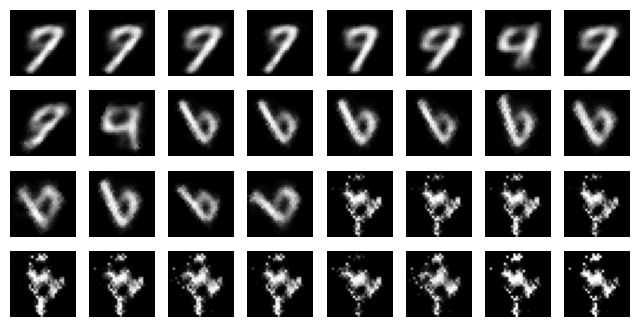

In [89]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [90]:
inp = iter(vae_trainer.eval_loader).next()

emb = model_rec(inp).z.detach().cpu()
recon = model_rec(inp).recon_x.detach().cpu()

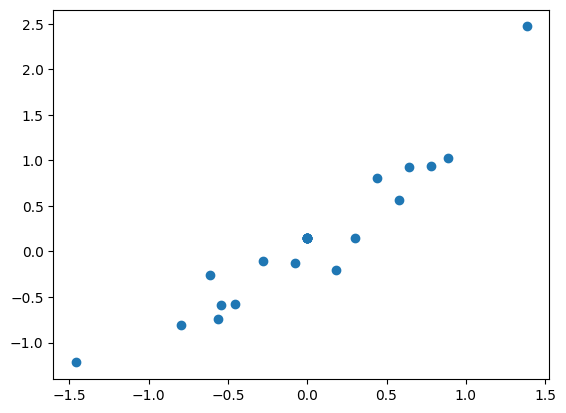

In [91]:
plt.scatter(emb[:8, 0], emb[:8, 1])

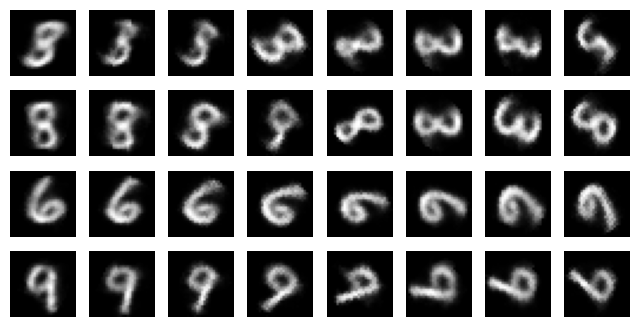

In [92]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim


config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=64
)

encoder = VAEEncoder(config)
decoder = VAEDecoder(config)

vae = VAE(config, encoder, decoder).cuda()


train_dataset = DynBinarizedMNIST(train_data.reshape(-1, 784))
eval_dataset = DynBinarizedMNIST(eval_data.reshape(-1, 784))

training_config = BaseTrainerConfig(
    num_epochs=10,
    learning_rate=1e-3,
    batch_size=100
)

### Optimizer
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
vae_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    vae_optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

vae_trainer = BaseTrainer(
        model=vae,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        training_config=training_config,
        optimizer=vae_optimizer,
        scheduler=vae_scheduler,
        callbacks=None,
    )

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
vae_trainer.train()

Model passed sanity check !

Created dummy_output_dir/VAE_training_2022-10-13_19-18-50. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/10: 100%|██████████| 800/800 [00:01<00:00, 768.99batch/s]
--------------------------------------------------------------------------
Train loss: 54.8252
Eval loss: 48.6898
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 2/10: 100%|██████████| 800/800 [00:01<00:00, 789.56batch/s]
--------------------------------------------------------------------------
Train loss: 45.2076
Eval loss: 43.1598
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 3/10: 100%|██████████| 800/800 [00:01<00:00, 749.15batch/s]
--------------------------------------------------------------------------
Train loss: 41.8885
Eval loss: 41.1367
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 4/10: 100%|██████████| 800/800 [00:01<00:00, 570.01batch/s]
--------------------------------------------------------------------------
Train loss: 40.1299
Eval loss: 39.8528
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 5/10: 100%|██████████| 800/800 [00:01<00:00, 555.45batch/s]
--------------------------------------------------------------------------
Train loss: 38.8872
Eval loss: 38.416
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 6/10: 100%|██████████| 800/800 [00:01<00:00, 749.60batch/s]
--------------------------------------------------------------------------
Train loss: 37.6678
Eval loss: 37.5022
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 7/10: 100%|██████████| 800/800 [00:01<00:00, 742.98batch/s]
--------------------------------------------------------------------------
Train loss: 36.9572
Eval loss: 36.9417
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 8/10: 100%|██████████| 800/800 [00:01<00:00, 772.70batch/s]
--------------------------------------------------------------------------
Train loss: 36.4688
Eval loss: 36.6219
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 9/10: 100%|██████████| 800/800 [00:01<00:00, 748.73batch/s]
--------------------------------------------------------------------------
Train loss: 36.0954
Eval loss: 36.231
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Eval of epoch 10/10: 100%|██████████| 800/800 [00:01<00:00, 722.19batch/s]
--------------------------------------------------------------------------
Train loss: 35.8031
Eval loss: 36.0207
--------------------------------------------------------------------------
Training ended!
Saved final model in dummy_output_dir/VAE_training_2022-10-13_19-18-50/final_model


Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
model_rec = vae#trainer._best_model

In [ ]:
z = torch.rand(10, 64).cuda()
gen = model_rec.decoder(z).reconstruction.detach().cpu()
gen.shape

torch.Size([10, 1, 28, 28])

IndexError: index 1 is out of bounds for dimension 1 with size 1

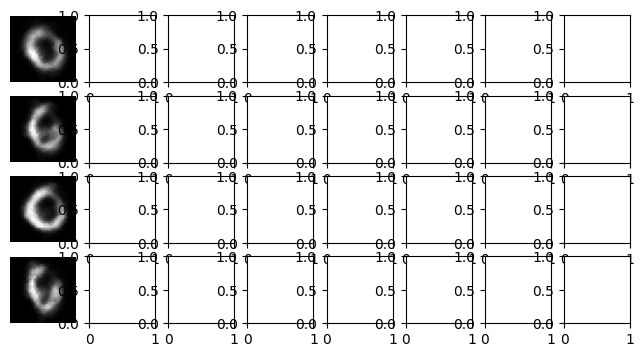

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
inp = iter(vae_trainer.eval_loader).next()

emb = model_rec(inp).z.detach().cpu()

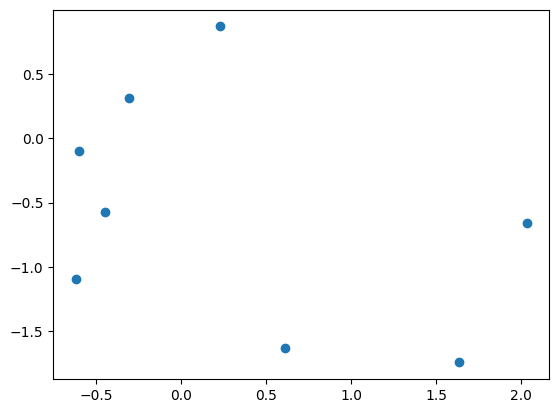

In [ ]:
plt.scatter(emb[:8, 0], emb[:8, 1])

IndexError: index 1 is out of bounds for dimension 1 with size 1

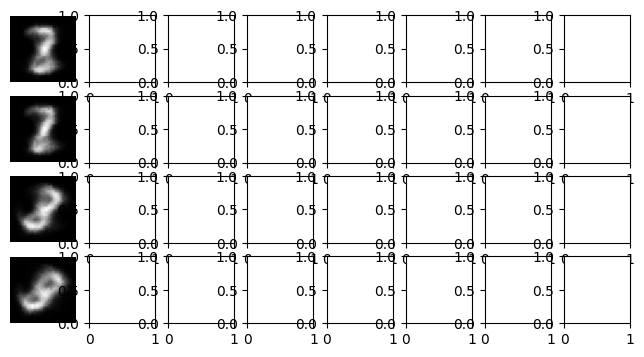

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

## LVAE

In [18]:
from pythae.models import LVAE_IAF, LVAE_IAF_Config

config = LVAE_IAF_Config(
    input_dim=(1, 28, 28),
    n_obs_per_ind=18,
    latent_dim=2,
    n_hidden_in_made=3,
    n_made_blocks=3,
    warmup=50,
    context_dim=32
)

encoder = Encoder(config)
decoder = Decoder(config)

model = LVAE_IAF(config, encoder, decoder).cuda()
model

LVAE_IAF(
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=200, bias=True)
    (fc3): Linear(in_features=200, out_features=784, bias=True)
  )
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=200, bias=True)
    (embedding): Linear(in_features=200, out_features=2, bias=True)
    (log_var): Linear(in_features=200, out_features=2, bias=True)
    (context): Linear(in_features=200, out_features=32, bias=True)
  )
  (flows): ModuleList(
    (0): IAF(
      (net): ModuleList(
        (0): MADE(
          (context_input_layer): MaskedLinear(
            in_features=2, out_features=128, bias=True
            (context_linear): Linear(in_features=32, out_features=128, bias=False)
          )
          (net): Sequential(
            (0): MaskedLinear(in_features=128, out_features=128, bias=True)
            (1): ReLU()
            

In [19]:
_ = model({'data': next(iter(train_loader))[0][:5].cuda().reshape((-1, 18, 28*28)).float()}, epoch=0)

In [20]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim

training_config = BaseTrainerConfig(
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64
)

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

trainer = BaseTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        training_config=training_config,
        optimizer=optimizer,
        scheduler=scheduler,
        callbacks=None,
    )

Adjusting learning rate of group 0 to 1.0000e-03.


In [25]:
next(iter(trainer.train_loader))[0]

tensor([[[[[[[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             ...,
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.]],

            [[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             ...,
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.]],

            [[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             ...,
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.]]]]],




         [[[[[0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0., 0., 0.],
             [0., 0., 0.,  ..., 0.

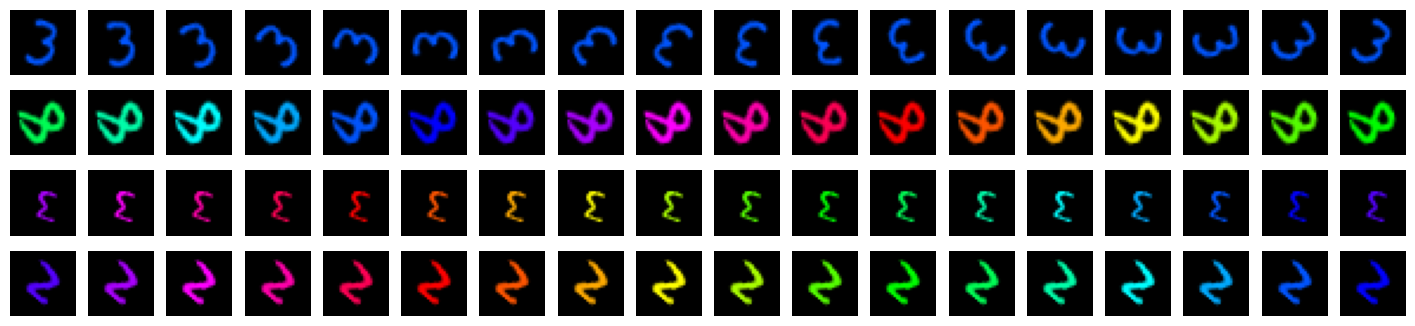

In [29]:
inp = iter(trainer.train_loader).next()[0]

lim = 18
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(inp))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[3][k].axis('off')

In [30]:
#model.warmup = 0
trainer.train()

ModelError: Error when calling forward method from model. Potential issues: 
 - Wrong model architecture -> check encoder, decoder and metric architecture if you provide yours 
 - The data input dimension provided is wrong -> when no encoder, decoder or metric provided, a network is built automatically but requires the shape of the flatten input data.
Exception raised: <class 'AttributeError'> with message: 'list' object has no attribute 'keys'

In [162]:
model_rec = model

In [164]:
z = torch.randn(10, 2).cuda()

In [165]:
gen = model_rec.generate(z).detach().cpu()
gen.shape

torch.Size([10, 8, 1, 28, 28])

Training of epoch 1/100:   4%|▍         | 7/157 [01:54<40:53, 16.36s/batch]


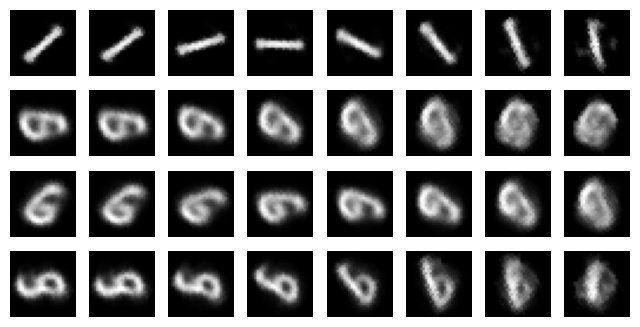

In [166]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(train_data))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [167]:
inp = iter(trainer.eval_loader).next()

output = model_rec(inp, epoch=100000)
recon = output.recon_x.detach()
z_seq = output.z_seq.detach()

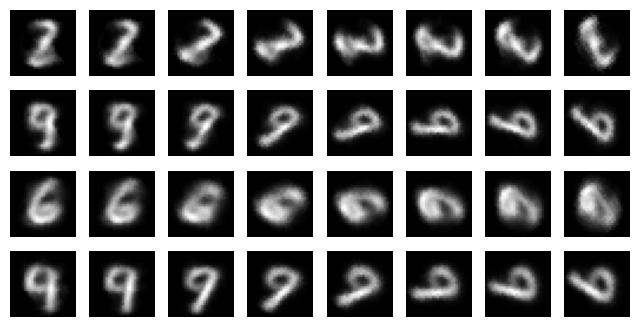

In [168]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

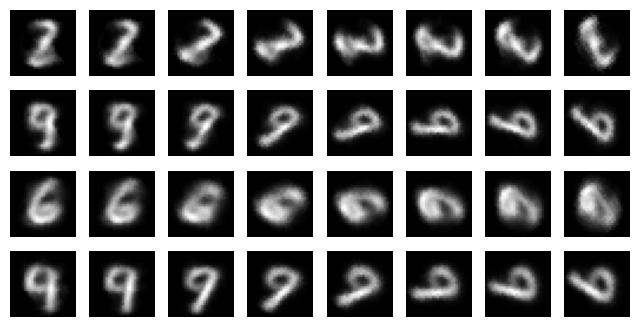

Training of epoch 54/100:  71%|███████▏  | 112/157 [00:21<00:02, 21.85batch/s]

In [169]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [170]:
inp.data.shape

torch.Size([64, 8, 784])

In [211]:
a = torch.tensor([[1], [2], [3]])
a.repeat(1, 2).reshape(-1, 1)

tensor([[1],
        [1],
        [2],
        [2],
        [3],
        [3]])

In [218]:
inp = iter(trainer.eval_loader).next()

output = model_rec({'data': inp.data[:10].repeat(1, 64, 1).reshape(-1, 8, 784)}, epoch=100000)
recon = output.recon_x.detach()
z_seq = output.z_seq.detach()

4


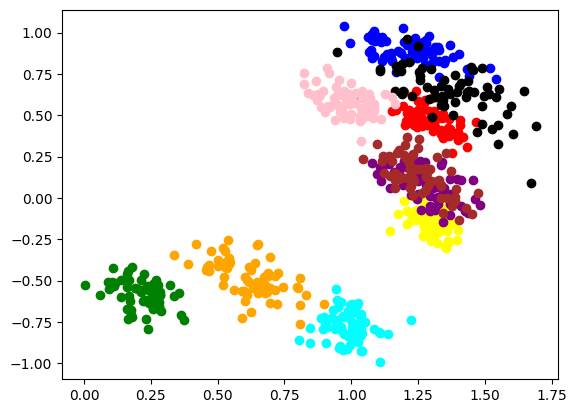

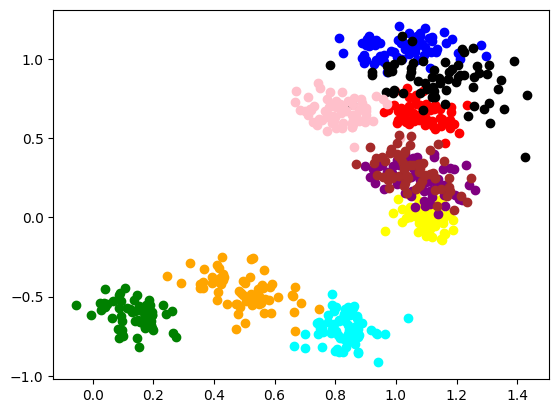

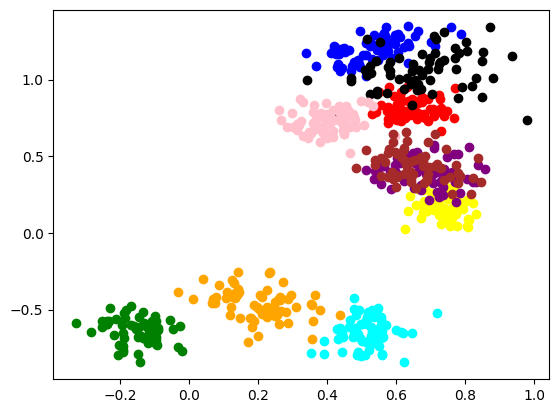

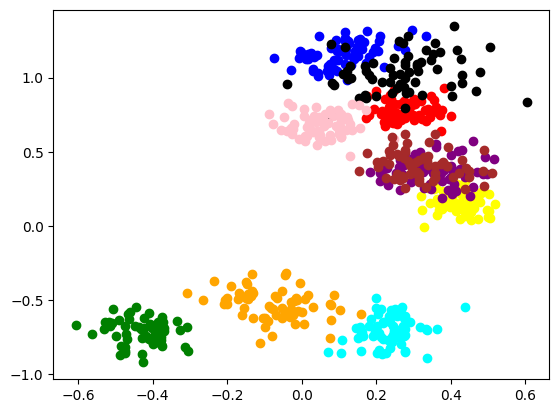

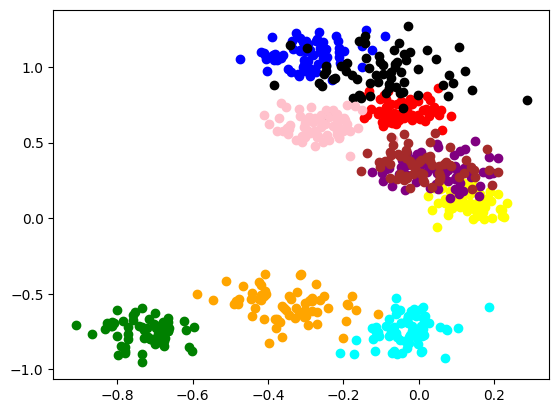

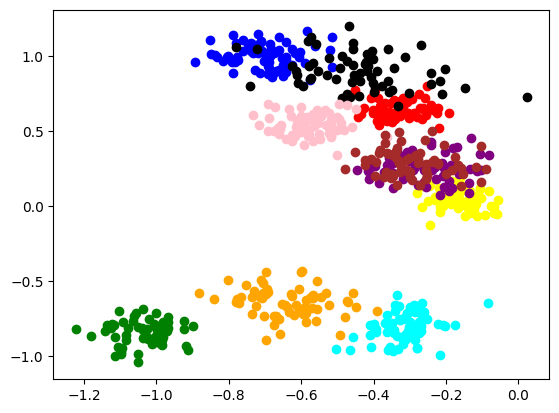

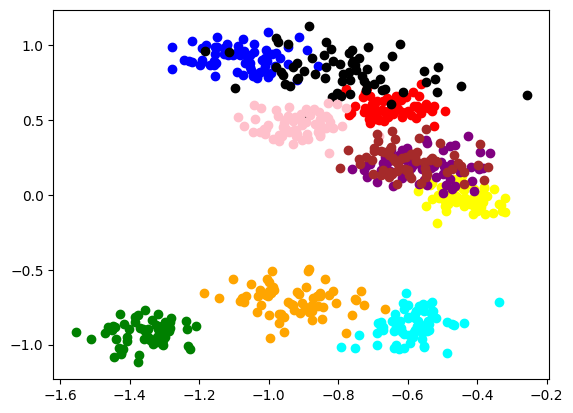

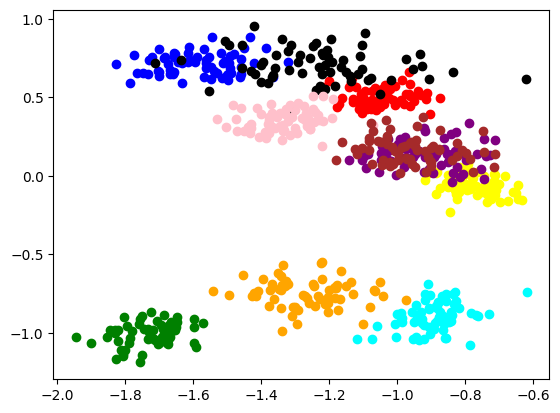

In [219]:
c = ['b', 'r', 'orange', 'yellow','cyan', 'purple', 'green', 'black', 'pink', 'brown']
for i in range(8):
    for j in range(10):
        plt.scatter(z_seq[64*j:64*(j+1), i, 0].cpu(), z_seq[64*j:64*(j+1), i, 1].cpu(), c=c[j])
    plt.show()

RuntimeError: shape '[28, 28]' is invalid for input of size 4096

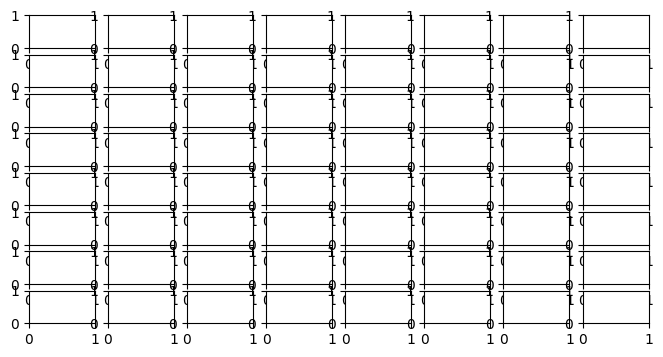

In [26]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(eval_data))

# Train recon
fig, axes = plt.subplots(8, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 1, k
    axes[2][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    axes[3][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')
    i, t = 2, k
    axes[4][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[4][k].axis('off')
    axes[5][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[5][k].axis('off')
    i, t = 3, k
    axes[6][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[6][k].axis('off')
    axes[7][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[7][k].axis('off')